In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import torch

### Set base parameters

In [23]:
# 設定訓練參數
max_length = 32
batch_size = 6
#batch_size = 32
learning_rate = 1e-4
num_epochs = 100

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

model_name = 'TF2_with_hanja_no_zy_zhtokenizer_v2'
dir_path = '.'
#dir_path = '/content/drive/MyDrive/ZH-KO-TRANSLATOR'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load data

## Read sentence for each ALIGNED article csv file with train set and test set.

In [3]:
df_train_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TRAIN_ALL.csv'.format(dir_path))
df_train_transcript = df_train_transcript.to_dict(orient='dict')

TRAIN_KSENT = (list(df_train_transcript['KO'].values()))
TRAIN_KSENT.remove('\"')

TRAIN_ZSENT = (list(df_train_transcript['ZH'].values()))
TRAIN_ZSENT.remove('”')

TRAIN_HSENT = (list(df_train_transcript['HANJA_Z'].values()))
TRAIN_HSENT.remove('\"')

#TRAIN_HSENT = (list(df_train_transcript['HANJA_K'].values()))
#TRAIN_HSENT.remove('\"')

print(len(TRAIN_KSENT))
df_train_transcript = []

146660


In [4]:
df_test_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TEST_ALL.csv'.format(dir_path))
df_test_transcript = df_test_transcript.to_dict(orient='dict')

TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH'].values()))
TEST_HSENT = (list(df_test_transcript['HANJA_Z'].values()))
#TEST_HSENT = (list(df_test_transcript['HANJA_K'].values()))

df_test_transcript = []
print(len(TEST_KSENT))

36089


In [5]:
df_train_zhuyin = pd.read_csv('{}/CORPUS/ZHUYIN/ZHUYIN_TRAIN_ALL.csv'.format(dir_path))
df_train_zhuyin = df_train_zhuyin.to_dict(orient='dict')

TRAIN_ZYSENT = (list(df_train_zhuyin['zhuyin'].values()))
TRAIN_ZYSENT.remove(np.nan)
TRAIN_ZYSENT = [sent.replace('\n','') for sent in TRAIN_ZYSENT]

df_train_zhuyin = []
print(len(TRAIN_ZYSENT))

146660


In [6]:
df_test_zhuyin = pd.read_csv('{}/CORPUS/ZHUYIN/ZHUYIN_TEST_ALL.csv'.format(dir_path))
df_test_zhuyin = df_test_zhuyin.to_dict(orient='dict')

TEST_ZYSENT = [sent.replace('\n','') for sent in (list(df_test_zhuyin['zhuyin'].values()))]

df_test_transcript = []
print(len(TEST_ZYSENT))

36089


In [7]:
train_delete_indexs = {}
for i in range(len(TRAIN_ZSENT)):
    if(len(TRAIN_ZSENT[i]) < 3 or len(TRAIN_KSENT[i]) < 3):
        train_delete_indexs[i] = 1
        print(i,TRAIN_ZSENT[i], TRAIN_KSENT[i])

1685 （掌聲） 박수
2315 不! 절대! 아닙니다!
6228 嗨。 안녕하세요.
6447 謝謝 감사합니다.!
9080 好! 알겠습니다.
10567 是的。 네.
11806 十？ 열 개? 우리는 질문해야 합니다.
11991 」 ”
13214 嗨。 안녕하세요.
14710 不。 아뇨.
31278 好。 좋아요.
33767 好。 좋습니다.
34090 什麼？ 뭐라
36726 不！ 아니죠.
39959 嗨！ 안녕하세요.
40878 你。 바로 여러분입니다.
46783 謝謝 감사합니다
51043 哇。 오우.
64302 好。 좋아요.
66859 」 " 저.. 회사의 관리자가 당신에게 심장 판막을 보내지 않기로 결정했습니다.
74805 人。 무언가는, 어 딘가는 언제나 변했을 겁니다.
76821 嗨！ 신발끈에도 패턴이 있기 때문입니다.
77330 在她於1917年過世時，這些夢想仍未實現。 ”
77331 」 감사합니다.
82234 摸。 이분은 조나 단이고 37세이며 석사 학위를 가지고 있습니다.
88883 因為和穆斯林結盟來對抗基督教夥伴所造成的憤怒讓他也失去了所有剩下的當地支援。 "
88884 」 다른 방법으로는 생각지도 못할 아이디어를 얻을 수 있습니다.
89997 好。 눈은 계속 감고 계시 고요 차이점을 들으셨나요?
93311 嗨。 제 수염이 반쪽만 있는 걸 눈치 채셨을 겁니다.
94843 透過讚美自由言論及讚頌平凡英雄，他的劇作讓觀眾在歡笑的同時也能有所思考。 "
94844 」 감사합니다.
98549 好。 모두 앉아 주세요.
100655 當時，我一直有修練松濤館空手道，從我有印象以來都在練，所以我已經拿了黑帶。 네.
101007 對？ ( 웃음) 이 시계의 무게는 기계적으로 조정되어서 계속해서 천천히 작동하도록 되어 있습니다.
105530 嗨！ ( 박수와 함성) 2020년 3월 이후로 사람들 보는 게 처음이에요.
108350 很多那些成功的男人都不喜歡聽到我說為什麼我不需要男朋友。 네.
110284 謝謝 그리고 우리가 다음에 가야 할 길을 방향 잡을 수 있을 것입니다.
113692 樹。 ( 긁는 소리) 이렇

In [8]:
print(len(train_delete_indexs.keys()))
print(len(TRAIN_ZSENT))

48
146660


In [9]:
reverse_train_delete_indexs = list(train_delete_indexs.keys())
reverse_train_delete_indexs.reverse()
for i in reverse_train_delete_indexs:
    print(i,TRAIN_ZSENT[i], TRAIN_KSENT[i], TRAIN_HSENT[i], TRAIN_ZYSENT[i])
    del TRAIN_ZSENT[i]
    del TRAIN_KSENT[i]
    del TRAIN_HSENT[i]
    del TRAIN_ZYSENT[i]

141947 不。 아닙니다. 아닙니다. ㄅㄨˋ。
137408 「是的」什麼？ 네. 네. 「ㄕˋㄉㄜ˙」ㄕㄣˊㄇㄜ˙？
136650 」 " " 」
133673 」 " " 」
123519 」 ” ” 」
122336 不！ 아니죠! 아니죠! ㄅㄨˋ！
120470 酷！ 오 멋져요. 吳 멋져요. ㄎㄨˋ！
120433 不！ 안돼요! 안돼요! ㄅㄨˋ！
118934 這是波普舞。 " " ㄓㄜˋㄕˋㄅㄛㄆㄨˇㄨˇ。
118078 掌聲 감사합니다. 感謝합니다. ㄓㄤˇㄕㄥ
113692 樹。 ( 긁는 소리) 이렇게 말 야. ( 비트 박스) ( 트럼펫 소리) ( 비트 박스) ( 비트 박스) 기본으로 돌아가. ( 비트 박스) ( 비트 박스) 넌 이 소리를 알아. ( 비트 박스) 소리질러. ( 박수와 환호) ( 휘파람 소리) ( 박수와 환호) 감사합니다. ( 긁는 小吏) 이렇게 末 野. ( 비트 박스) ( 트럼펫 疏籬) ( 비트 박스) ( 비트 박스) 基本分以 돌아가. ( 비트 박스) ( 비트 박스) 넌 이 疏籬를 알我. ( 비트 박스) 소리질러. ( 薄收와 歡呼) ( 휘파람 疏籬) ( 樸樹와 歡呼) 感謝합니다. ㄕㄨˋ。
110284 謝謝 그리고 우리가 다음에 가야 할 길을 방향 잡을 수 있을 것입니다. 그리高 郵履家 多飮에 枷야 할 吉乙 방향 雜乙 수 있을 것입니다. ㄒㄧㄝˋㄒㄧㄝˋ
108350 很多那些成功的男人都不喜歡聽到我說為什麼我不需要男朋友。 네. 네. ㄏㄣˇㄉㄨㄛㄋㄚˋㄒㄧㄝㄔㄥˊㄍㄨㄥㄉㄜ˙ㄋㄢˊㄖㄣˊㄉㄡㄅㄨˋㄒㄧˇㄏㄨㄢ˙ㄊㄧㄥㄉㄠˋㄨㄛˇㄕㄨㄛㄨㄟˋㄕㄣˊㄇㄜ˙ㄨㄛˇㄅㄨˋㄒㄩㄧㄠˋㄋㄢˊㄆㄥˊㄧㄡ˙。
105530 嗨！ ( 박수와 함성) 2020년 3월 이후로 사람들 보는 게 처음이에요. ( 薄收와 喊聲) 2020년 3月 莅候路 사람들 보는 게 처음裏에요. ㄏㄞ！
101007 對？ ( 웃음) 이 시계의 무게는 기계적으로 조정되어서 계속해서 천천히 작동하도록 되어 있습니다. ( 웃음) 利 시계疑 무게는 기계적乙奴 조정되어서 계속해서 천천히 作動河都錄 되於 있습니다. ㄉㄨㄟˋ？
100655 當時，我一直

In [10]:
test_delete_indexs = {}
for i in range(len(TEST_ZSENT)):
    if(len(TEST_ZSENT[i]) < 3 or len(TEST_KSENT[i]) < 3):
        test_delete_indexs[i] = 1
        print(i,TEST_ZSENT[i], TEST_KSENT[i])

3566 」 "
5206 」 "
6312 不。 아닙니다.
10187 是的。 네.
11109 好。 좋아요.
12403 嗨。 안녕하세요?
12441 」 ”
12901 不！ 아닙니다!
15159 謝謝 감사합니다.
17733 不。 아닙니다.
18956 是的。 네.
19868 」 "
22513 好。 좋아요.
23679 」 " 는 말을 요.
25285 冰。 얼음이고요.
29343 嗨！ 그러니까... 안녕하세요!
34778 不。 아니죠.


In [11]:
print(len(test_delete_indexs.keys()))
print(len(TEST_ZSENT))

17
36089


In [12]:
reverse_test_delete_indexs = list(test_delete_indexs.keys())
reverse_test_delete_indexs.reverse()
for i in reverse_test_delete_indexs:
    print(i,TEST_ZSENT[i], TEST_KSENT[i], TEST_HSENT[i], TEST_ZYSENT[i])
    del TEST_ZSENT[i]
    del TEST_KSENT[i]
    del TEST_HSENT[i]
    del TEST_ZYSENT[i]

34778 不。 아니죠. 아니죠. ㄅㄨˋ。
29343 嗨！ 그러니까... 안녕하세요! 그러니까... 晏寧하세요! ㄏㄞ！
25285 冰。 얼음이고요. 乻音이皐陶. ㄅㄧㄥ。
23679 」 " 는 말을 요. " 는 末乙 요. 」
22513 好。 좋아요. 좋아요. ㄏㄠˇ。
19868 」 " " 」
18956 是的。 네. 네. ㄕˋㄉㄜ˙。
17733 不。 아닙니다. 아닙니다. ㄅㄨˋ。
15159 謝謝 감사합니다. 感謝합니다. ㄒㄧㄝˋㄒㄧㄝˋ
12901 不！ 아닙니다! 아닙니다! ㄅㄨˋ！
12441 」 ” ” 」
12403 嗨。 안녕하세요? 晏寧河세요? ㄏㄞ。
11109 好。 좋아요. 좋아요. ㄏㄠˇ。
10187 是的。 네. 네. ㄕˋㄉㄜ˙。
6312 不。 아닙니다. 아닙니다. ㄅㄨˋ。
5206 」 " " 」
3566 」 " " 」


In [13]:
print(len(TRAIN_ZSENT),len(TRAIN_KSENT),len(TRAIN_HSENT),len(TRAIN_ZYSENT))
print(len(TEST_ZSENT),len(TEST_KSENT),len(TEST_HSENT),len(TEST_ZYSENT))

146612 146612 146612 146612
36072 36072 36072 36072


In [14]:
print(TRAIN_ZYSENT[0])
print(TEST_ZYSENT[0])

ㄒㄧㄝˋㄒㄧㄝˋㄉㄚˋㄐㄧㄚ。
ㄨㄛˇㄒㄧㄤㄒㄧㄣˋㄖㄨˊㄍㄨㄛˇㄋㄧˇㄍㄟˇㄊㄚㄇㄣ˙ㄓㄥˋㄑㄩㄝˋㄉㄜ˙ㄈㄤㄈㄚˇㄏㄜˊㄍㄨㄥㄐㄩˋ，ㄊㄚㄇㄣ˙ㄎㄜˇㄧˇㄅㄚˇㄕㄢㄉㄡㄓㄨㄢˇㄧˊㄌㄜ˙ㄒㄧㄝˋㄒㄧㄝˋ（ㄍㄨˇㄓㄤˇㄕㄥ）


# Pretrain Model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Transformer

from transformers import BertTokenizer, BertModel, BertConfig, BertForPreTraining, AutoModel, BertTokenizerFast, BertForMaskedLM

import numpy as np
import matplotlib.pyplot as plt
import time
import math

## Load Tokenizer

In [16]:
import transformers
transformers.logging.set_verbosity_error() # solve the warning: 'Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.'

### Chinese Tokenizer

In [17]:
#zh_tokenizer = BertTokenizer.from_pretrained('{}/MODELS/TOKENIZER/new_zh_tokenizer_add_bpmf_korean_tokens_v2'.format(dir_path) )# load bert-base-chinese tokenizer with bpmf、hangul tokens(from 'kykim/bert-kor-base' and konlpy)
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [18]:
# zhuyin tokens
import re
zhuyins = ['ㄅ','ㄆ','ㄇ','ㄈ','ㄉ','ㄊ','ㄋ','ㄌ','ㄍ','ㄎ','ㄏ','ㄐ','ㄑ','ㄒ','ㄓ','ㄔ','ㄕ','ㄖ','ㄗ','ㄘ','ㄙ','ㄧ','ㄨ','ㄩ','ㄚ','ㄛ','ㄜ','ㄝ','ㄞ','ㄟ','ㄠ','ㄡ','ㄢ','ㄣ','ㄤ','ㄥ','ㄦ','ˇ','ˋ','ˊ','˙']

def check_bpmf_is_not(text):
    test_list = ['.*[ㄅㄆㄇㄈㄉㄊㄋㄌㄍㄎㄏㄐㄑㄒㄓㄔㄕㄖㄗㄘㄙㄧㄨㄩㄚㄛㄜㄝㄞㄟㄠㄡㄢㄣㄤㄥㄦˇˋˊ˙]+.*']
    for t in test_list:
        valid = re.compile(t)
        try:
            if(valid.match(text) != None):
                return True
        except:
            return False
    return False

zhuyin_df = pd.read_csv('{}/CORPUS/TOKEN/zhuyin_tokens_count.csv'.format(dir_path))
zhuyin_df = zhuyin_df.to_dict(orient='dict')
zhuyin_tokens = list(zhuyin_df['zhuyin'].values())
print(len(zhuyin_tokens))

for tok in zhuyin_tokens:
  if(check_bpmf_is_not(tok)):
    continue
  else:
    zhuyin_tokens.remove(tok)
print('zy:',len(zhuyins))
print('zy tokens:',len(zhuyin_tokens))

2751
zy: 41
zy tokens: 2089


In [19]:
# korean tokens
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
ko_tokenizer_tokens = list(ko_tokenizer.get_vocab().keys())
print(len(ko_tokenizer_tokens))

42000


In [20]:
# add new tokens
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
print('Original Length: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyins)
print('Add zhuyins: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyin_tokens)
print('Add zhuyin tokens: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(ko_tokenizer_tokens)
print('Add korean tokens from kykim/bert-kor-base tokenizer: ',len(zh_tokenizer))

Original Length:  21128
Add zhuyins:  21146
Add zhuyin tokens:  22839
Add korean tokens from kykim/bert-kor-base tokenizer:  63662


In [21]:
zh_bert_model = AutoModel.from_pretrained('ckiplab/bert-base-chinese')
zh_bert_model.resize_token_embeddings(len(zh_tokenizer))

Embedding(63662, 768)

### Korean Tokenizer

In [ ]:
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

In [ ]:
ko_bert_model = BertModel.from_pretrained("kykim/bert-kor-base")

### mbert

In [ ]:
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
mbert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)
mbert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

### chinese bert with phonetic

In [22]:
my_model = zh_bert_model
my_model = my_model.to(device)
my_model.eval()

#tgt_model = zh_bert_model
my_tokenizer = zh_tokenizer
tgt_tokenizer = zh_tokenizer


### Get Embeddings

In [ ]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = my_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[ 0.2751, -0.1491,  0.3304,  ..., -0.0059, -0.1405, -0.3108],
         [-0.1300, -0.3333,  1.0684,  ..., -0.2793, -0.3171, -0.4867],
         [ 0.2309, -0.4890,  0.1326,  ..., -0.0110, -0.2467, -0.8567],
         ...,
         [ 0.7320, -0.1392,  1.1718,  ...,  0.1636, -0.0037, -0.4018],
         [ 0.3692, -0.2858,  0.8215,  ...,  0.4665, -0.1487, -0.5134],
         [ 0.3086, -0.1198,  0.9983,  ...,  0.0486, -0.2033, -0.4707]]],
       device='cuda:0')


In [ ]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[-0.3986, -0.2009,  0.2008,  ...,  0.4399,  0.4141,  0.4691],
         [ 0.0838, -0.1388, -0.5705,  ...,  0.7849,  1.0852, -0.0710],
         [-0.0747, -0.3994, -0.6897,  ...,  0.2100, -0.6700,  0.0048],
         ...,
         [ 0.0286, -0.2309, -0.4041,  ...,  0.2663,  0.4609, -0.2155],
         [-0.3307, -0.4798, -0.5780,  ...,  0.7395,  0.8964,  0.0967],
         [-0.3986, -0.2009,  0.2007,  ...,  0.4400,  0.4141,  0.4692]]],
       device='cuda:0')


In [120]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = my_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state
print(embeddings.size())
print(embeddings)

embeddings = embeddings.permute(1,0,2)
print(embeddings.size())


print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
torch.Size([1, 32, 768])
tensor([[[-0.8633, -0.3071,  0.2674,  ...,  0.1599, -0.4286,  0.6708],
         [-0.6252, -0.6063, -0.1854,  ...,  0.6419,  0.8342, -0.1806],
         [-0.0089, -0.2781, -0.5571,  ..., -0.0188, -0.9018,  0.2421],
         ...,
         [-0.2869, -0.3825, -0.2250,  ...,  1.3278,  0.5709,  0.0547],
         [-0.3993, -0.6135, -0.6772,  ...,  1.2183,  0.6720, -0.0780],
         [-0.8633, -0.3071,  0.2673,  ...,  0.1600, -0.4286,  0.6708]]],
       device='cuda:0')
torch.Size([32, 1, 768])
tensor([[[-0.8633, -0.3071,  0.2674,  ...,  0.1599, -0.4286,  0.6708]],

        [[-0.6252, -0.6063, -0.1854,  ...,  0.6419,  0.8342, -0.1806]],

        [[-0.0089, -0.2781, -0.5571,  ..., -0.0188, -0.9018,  0.2421]],

        ...,

        [[-0.2869, -0.3825, -0.2250,  ...,  1.3278,  0.5709,  0.0547]],

        [[-0.3993, -0.6135, -0.6772,  ...,  1.2183,  0.6720, -0.0780]],

        [[-0.8633, -0.3071, 

In [ ]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = mbert_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(mbert_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101,   100, 10064,   100, 10064,   100,  1882,   102]],
       device='cuda:0')
， ， 。
tensor([[[ 0.1761,  0.2477,  0.2021,  ...,  0.0559,  0.0265,  0.0520],
         [-0.2596,  0.5538,  0.7481,  ...,  0.4942, -0.0487, -0.1889],
         [ 0.2373,  0.3286,  0.1775,  ...,  0.1499,  0.3106,  0.0685],
         ...,
         [-0.2755,  0.5195,  0.7319,  ...,  0.3360,  0.0062, -0.1785],
         [ 0.2210,  0.2828,  0.6919,  ...,  0.0976, -0.0144, -0.0212],
         [ 0.2256,  0.3239,  0.7765,  ...,  0.0071, -0.1020,  0.0957]]],
       device='cuda:0')


In [ ]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(zh_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101, 21212, 21314, 21222, 21160, 21298, 21178,  8024, 21847, 21669,
         21683, 21566, 22097, 21245, 21282,  8024, 21248, 21326, 21212, 21250,
         21176, 21159, 21463, 21158, 21164, 21160, 21293, 21178, 21212, 21330,
         21347, 21360,   511,   102]], device='cuda:0')
ㄉㄠˋ ㄗㄨㄟˋ ㄏㄡˋ ㄨㄛˇ ㄐㄩㄝˊ ㄉㄜ˙ ， ㄍㄢ ㄘㄨㄟˋ ㄑㄩ ㄈㄨˊ ㄠˊ ㄍㄨㄛˋ ㄑㄩˋ ， ㄓˋ ㄕㄠˇ ㄉㄠˋ ㄒㄧㄚˋ ㄘˋ ㄗㄞˋ ㄈㄚ ㄕㄥ ㄑㄧㄢˊ ㄨㄛˇ ㄋㄥˊ ㄉㄜ˙ ㄉㄠˋ ㄉㄧㄢˇ ㄆㄧㄥˊ ㄐㄧㄥˋ 。
tensor([[[ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912],
         [ 0.1583,  0.7188, -0.5311,  ...,  0.6539,  0.5927, -0.4165],
         [ 0.4785,  0.4971, -0.8335,  ...,  1.1260,  0.9367, -0.4509],
         ...,
         [-0.1669, -0.0682, -1.1579,  ...,  0.9067,  0.4017, -0.5816],
         [ 0.3379,  0.3454,  0.3881,  ...,  0.5396, -0.3149,  0.3823],
         [ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912]]],
       device='

## Build Dataset Function

In [ ]:
'''# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, hanja_sentences, bpmf_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.bpmf_sentences = bpmf_sentences
        self.hanja_sentences = hanja_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        bpmf = self.bpmf_sentences[index]
        hanja = self.hanja_sentences[index]
        #print(index)
        return source, target, bpmf, hanja'''


In [25]:
# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, hanja_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.hanja_sentences = hanja_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        hanja = self.hanja_sentences[index]

        source_token = my_tokenizer(source, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
        target_token = tgt_tokenizer(target, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
        hanja_token = my_tokenizer(hanja, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)



        #print(index)
        return source, target, hanja, source_token, target_token, hanja_token


### Data Loader

In [26]:
# 載入資料集
train_source_sentences = TRAIN_ZSENT  # 中文句子
train_target_sentences = TRAIN_KSENT  # 韓文句子
dataset = TranslationDataset(train_source_sentences, train_target_sentences, TRAIN_HSENT)
#dataset = TranslationDataset(train_source_sentences, train_target_sentences, TRAIN_ZYSENT, TRAIN_HSENT)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [27]:
test_source_sentences = TEST_ZSENT  # 中文句子
test_target_sentences = TEST_KSENT  # 韓文句子
test_dataset = TranslationDataset(test_source_sentences, test_target_sentences, TEST_HSENT)
#test_dataset = TranslationDataset(test_source_sentences, test_target_sentences, TEST_ZYSENT, TEST_HSENT)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
def get_pad_sequence(tokens,type_str):
    batch = [example[0] for example in tokens[type_str]]
    return  nn.utils.rnn.pad_sequence(batch, padding_value=pad_index)

In [29]:
start = time.time()
for batch in dataloader:
  #try:
        source, target, hanja, source_token, target_token, hanja_token  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
        #batch_src_ids = [example[0] for example in source_tokens['input_ids'] ]
        #batch_tgt_ids = [example[0] for example in target_tokens['input_ids']]

        #batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
        #batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)

        #batch_src_attentions = [example[0] for example in source_tokens['attention_mask'] ]
        #batch_tgt_attentions = [example[0] for example in target_tokens['attention_mask']]

        #batch_src_attentions = nn.utils.rnn.pad_sequence(batch_src_attentions, padding_value=pad_index)
        #batch_tgt_attentions = nn.utils.rnn.pad_sequence(batch_tgt_attentions, padding_value=pad_index)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids')
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids')
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask')
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask')
        '''
        #print('batch_src_ids',batch_src_ids)
        #print('batch_tgt_ids',batch_tgt_ids)
        #print('batch_src_attentions', batch_src_attentions)
        #print('batch_tgt_attentions', batch_tgt_attentions)
        #break
  #except:
  #      print('ERROR')
  #      break
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 40.49036431312561 s


In [30]:
start = time.time()
for batch in test_dataloader:
  #try:
        source, target, hanja, source_token, target_token, hanja_token  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
        #batch_src_ids = [example[0] for example in source_tokens['input_ids'] ]
        #batch_tgt_ids = [example[0] for example in target_tokens['input_ids']]

        #batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
        #batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)

        #batch_src_attentions = [example[0] for example in source_tokens['attention_mask'] ]
        #batch_tgt_attentions = [example[0] for example in target_tokens['attention_mask']]

        #batch_src_attentions = nn.utils.rnn.pad_sequence(batch_src_attentions, padding_value=pad_index)
        #batch_tgt_attentions = nn.utils.rnn.pad_sequence(batch_tgt_attentions, padding_value=pad_index)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids')
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids')
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask')
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask')
        '''
        #print('batch_src_ids',batch_src_ids)
        #print('batch_tgt_ids',batch_tgt_ids)
        #print('batch_src_attentions', batch_src_attentions)
        #print('batch_tgt_attentions', batch_tgt_attentions)
        #break
  #except:
  #      print('ERROR')
  #      break
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 10.006572008132935 s


## Build Model

### Set transformer parameter

In [31]:
src_vocab_size = len(my_tokenizer)
tgt_vocab_size = len(tgt_tokenizer)
embed_size = 768
ffn_hid_dim = 256
num_heads = 8
num_layers = 6

num_encoder_layers = 3
num_decoder_layers = 3

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

In [ ]:
special_tokens = ['[CLS]','[MASK]','[PAD]','[SEP]','[UNK]']
for ids in my_tokenizer(special_tokens)['input_ids']:
  print(ids , my_tokenizer.decode(ids))

[101, 101, 102] [CLS] [CLS] [SEP]
[101, 103, 102] [CLS] [MASK] [SEP]
[101, 0, 102] [CLS] [PAD] [SEP]
[101, 102, 102] [CLS] [SEP] [SEP]
[101, 100, 102] [CLS] [UNK] [SEP]


### Initialize Model

In [ ]:
'''class TranslationModel(nn.Module):
    def __init__(self, bert_model, vocab_size, embed_size, num_heads, num_layers, max_length):
        super(TranslationModel, self).__init__()
        self.embedding = bert_model
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, src, tgt, attention_mask, src_mask=None, tgt_mask=None, memory_mask=None):
    #def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, attention_mask, hanja_ids, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):
        src_seq_length = src.size(0)
        tgt_seq_length = tgt.size(0)
        print('src_seq_length:',src_seq_length)

        src_pos = torch.arange(0, src_seq_length).unsqueeze(1).to(device)
        tgt_pos = torch.arange(0, tgt_seq_length).unsqueeze(1).to(device)

        src = self.embedding(src).last_hidden_state + self.position_embedding(src_pos)
        tgt = self.embedding(tgt).last_hidden_state + self.position_embedding(tgt_pos)

        memory = self.transformer.encoder(src, src_key_padding_mask=src_mask)
        out = self.transformer.decoder(tgt, memory, tgt_key_padding_mask=tgt_mask, memory_key_padding_mask=memory_mask)
        out = self.fc(out)

        return out'''

"class TranslationModel(nn.Module):\n    def __init__(self, bert_model, vocab_size, embed_size, num_heads, num_layers, max_length):\n        super(TranslationModel, self).__init__()\n        self.embedding = bert_model\n        self.position_embedding = nn.Embedding(max_length, embed_size)\n        self.transformer = nn.Transformer(\n            d_model=embed_size,\n            nhead=num_heads,\n            num_encoder_layers=num_layers,\n            num_decoder_layers=num_layers\n        )\n        self.fc = nn.Linear(embed_size, vocab_size)\n\n    def forward(self, src, tgt, attention_mask, src_mask=None, tgt_mask=None, memory_mask=None):\n    #def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, attention_mask, hanja_ids, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):\n        src_seq_length = src.size(0)\n        tgt_seq_length = tgt.size(0)\n        print('src_seq_length:',src_seq_length)\n\n        src_pos = torch.arange(0, src_seq_length).unsqueeze(

In [70]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, bert_model, src_vocab_size: int = src_vocab_size, tgt_vocab_size: int = tgt_vocab_size, emb_size = embed_size, dropout_prob = 0.1):
        super(TokenEmbedding, self).__init__()
        #self.embedding = bert_model
        self.emb_size = emb_size
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        #print('embedding size:',self.embedding(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.size())
        embed = my_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        #output = embed * math.sqrt(self.emb_size)
        output = self.dropout(embed)
        return output

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 bert_model,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(bert_model)
        self.tgt_tok_emb = TokenEmbedding(bert_model)
        self.hanja_tok_emb = TokenEmbedding(bert_model)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src_input_ids, src_attention_mask,
                tgt_input_ids, tgt_attention_mask,
                hanja_input_ids, hanja_attention_mask,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor=None):
        #src_emb = self.positional_encoding(self.src_tok_emb(src_input_ids, src_attention_mask))
        src_emb = self.src_tok_emb(src_input_ids, src_attention_mask)
        src_emb = src_emb.permute(1,0,2)#.contiguous()
        #print('src_emb (no_positional):',src_emb)

        src_emb = self.positional_encoding(src_emb)
        #print('src_emb (after_positional):',src_emb)
        #tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask))
        tgt_emb = self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask)
        tgt_emb = tgt_emb.permute(1,0,2)#.contiguous()
        #print('tgt_emb (no_positional):',tgt_emb)
        tgt_emb = self.positional_encoding(tgt_emb)
        #print('tgt_emb (after_positional):',tgt_emb)


        hanja_emb = self.tgt_tok_emb(hanja_input_ids, hanja_attention_mask)
        hanja_emb = hanja_emb.permute(1,0,2)#.contiguous()
        #print('tgt_emb (no_positional):',tgt_emb)
        hanja_emb = self.positional_encoding(hanja_emb)

        joint_emb = self.dropout(src_emb * 0.5 + hanja_emb * 0.5)

        #src_mask = src_mask.permute(1,0)
        #tgt_mask = tgt_mask.permute(1,0)
        #src_padding_mask = src_padding_mask.permute(1,0)
        #tgt_padding_mask = tgt_padding_mask.permute(1,0)
        #print('src_mask = ',src_mask)
        #print('tgt_mask = ',tgt_mask)
        #print('src_padding_mask = ',src_padding_mask)
        #print('tgt_padding_mask = ',tgt_padding_mask)

        outs = self.transformer(joint_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        #print('outs (in model):',outs)
        return self.generator(outs)

    def encode(self, src_input_ids, src_attention_mask, src_mask: Tensor):
        #return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src_input_ids, src_attention_mask)), src_mask)
        src_emb = self.src_tok_emb(src_input_ids, src_attention_mask).permute(1,0,2)#.contiguous()
        #print('encode size:',src_emb.size())
        return self.transformer.encoder(self.positional_encoding(src_emb), src_mask.permute(1,0))

    def decode(self, tgt_input_ids, tgt_attention_mask, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask).permute(1,0,2)#.contiguous()
        #print('decode_size:',tgt_emb.size())
        #print('memory_size',memory.size())
        return self.transformer.decoder(self.positional_encoding(tgt_emb), memory,tgt_mask)#.permute(1,0))
        #return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask)), memory,tgt_mask)

In [71]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src = src.permute(1,0)
    tgt = tgt.permute(1,0)
    #print('src',src.size())
    #print('tgt',tgt.size())
    try:
        src_seq_len = src.shape[0]
        tgt_seq_len = tgt.shape[0]
    except:
        src_seq_len = max_length
        tgt_seq_len = max_length


    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == pad_index).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_index).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask.size())
    #print('tgt_padding_mask',tgt_padding_mask.size())
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [72]:
torch.manual_seed(0)

transformer = Seq2SeqTransformer(my_model, num_encoder_layers, num_decoder_layers, embed_size,
                                 num_heads, src_vocab_size, tgt_vocab_size, ffn_hid_dim)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = transformer.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
'''class TranslationModel(nn.Module):
    def __init__(self, bert_model, dropout_prob=0.1):
        super(TranslationModel, self).__init__()
        self.bert1 = bert_model
        #self.bert2 = bert_model
        self.bert3 = bert_model
        self.dropout1 = nn.Dropout(dropout_prob)
        #self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert1.config.hidden_size, len(tgt_tokenizer))

    def forward(self, input_ids, hanja_ids, attention_mask, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):
        zh_outputs = self.bert1(input_ids=input_ids, attention_mask=attention_mask)
        #bpmf_outputs = self.bert2(input_ids=bpmf_ids, attention_mask=bpmf_attention_mask)
        hanja_outputs = self.bert3(input_ids=hanja_ids, attention_mask=hanja_attention_mask)

        # Apply dropout
        zh_outputs = self.dropout1(zh_outputs.last_hidden_state)
        #bpmf_outputs = self.dropout2(bpmf_outputs.last_hidden_state)
        hanja_outputs = self.dropout3(hanja_outputs.last_hidden_state)

        # Combine representations
        combined_outputs = 0.5 * zh_outputs + 0.5 * hanja_outputs # + 0.25 * bpmf_outputs

        prediction_scores = self.linear(combined_outputs)
        return prediction_scores'''


'class TranslationModel(nn.Module):\n    def __init__(self, bert_model, dropout_prob=0.1):\n        super(TranslationModel, self).__init__()\n        self.bert1 = bert_model\n        #self.bert2 = bert_model\n        self.bert3 = bert_model\n        self.dropout1 = nn.Dropout(dropout_prob)\n        #self.dropout2 = nn.Dropout(dropout_prob)\n        self.dropout3 = nn.Dropout(dropout_prob)\n        self.linear = nn.Linear(self.bert1.config.hidden_size, len(tgt_tokenizer))\n\n    def forward(self, input_ids, hanja_ids, attention_mask, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):\n        zh_outputs = self.bert1(input_ids=input_ids, attention_mask=attention_mask)\n        #bpmf_outputs = self.bert2(input_ids=bpmf_ids, attention_mask=bpmf_attention_mask)\n        hanja_outputs = self.bert3(input_ids=hanja_ids, attention_mask=hanja_attention_mask)\n\n        # Apply dropout\n        zh_outputs = self.dropout1(zh_outputs.last_hidden_state)\n        #bpmf_outputs = self.dropout2(bpmf

In [ ]:
'''# 初始化模型、損失函數和優化器
model = TranslationModel(my_model, vocab_size, embed_size, num_heads, num_layers, max_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)'''

'# 初始化模型、損失函數和優化器\nmodel = TranslationModel(my_model, vocab_size, embed_size, num_heads, num_layers, max_length).to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=learning_rate)'

In [ ]:
# 加載訓練好的模型
#model = TranslationModel(model_mbert).to(device)
model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))

<All keys matched successfully>

### Train and Evaluate

In [35]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time%60)
  return elapsed_mins, elapsed_secs

In [49]:
!pip install tqdm

In [36]:
from tqdm import tqdm

In [37]:
def train(path):
    global model, dataloader, optimizer, criterion, my_tokenizer, tgt_tokenizer
    model.train()
    total_loss = 0
    counts = 0
    with tqdm(total = len(dataloader)) as pbar:
      for batch in dataloader:
        source, target, hanja, source_tokens, target_tokens, hanja_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch

        batch_src_ids = source_tokens.input_ids#.to(device)
        batch_tgt_ids = target_tokens.input_ids#.to(device)
        batch_hanja_ids = hanja_tokens.input_ids#.to(device)

        batch_src_attentions = source_tokens.attention_mask#.to(device)
        batch_tgt_attentions = target_tokens.attention_mask#.to(device)
        batch_hanja_attentions = hanja_tokens.attention_mask#.to(device)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids').to(device)
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids').to(device)
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask').to(device)
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask').to(device)
        '''
        optimizer.zero_grad()

        #tgt_input = batch_tgt_ids[:-1,:]
        #tgt_input_attention_mask = batch_tgt_attentions[:-1,:]
        #print('batch_src_ids',batch_src_ids.size())
        #print('batch_tgt_ids',batch_tgt_ids.size())
        src_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_src_ids]).to(device)
        tgt_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length-1] for ids in batch_tgt_ids]).to(device)
        hanja_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_hanja_ids]).to(device)
        src_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_src_attentions]).to(device)
        tgt_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length-1] for attn in batch_tgt_attentions]).to(device)
        hanja_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_hanja_attentions]).to(device)
        #print('src_input',src_input.size())
        #print('tgt_input',tgt_input.size())
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_input, tgt_input)
        output = model(src_input_ids=src_input,
                       tgt_input_ids=tgt_input,
                       hanja_input_ids=hanja_input,
                       src_attention_mask=src_input_attention_mask,
                       tgt_attention_mask=tgt_input_attention_mask,
                       hanja_attention_mask=hanja_input_attention_mask,
                       src_mask=src_mask,
                       tgt_mask=tgt_mask,
                       src_padding_mask=src_padding_mask,
                       tgt_padding_mask=tgt_padding_mask,
                       memory_key_padding_mask=None
                       )

        #tgt_out = batch_tgt_ids[1:,:]
        tgt_out = torch.LongTensor([ids.cpu().numpy()[0][1:] for ids in batch_tgt_ids]).to(device)
        #print('output_',output.size())
        #print('output',output)
        #print('output.transpose(0,1)',output.transpose(0,1).size())
        #print('output.reshape(-1,output.shape[-1])',output.reshape(-1,output.shape[-1]))
        #print('tgt_out.reshape(-1)',tgt_out.reshape(-1))
        #print('tgt_out',tgt_out.size())

        #loss = criterion(output, tgt_out)
        loss = criterion(output.transpose(0,1).reshape(-1,output.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        counts += batch_size
        loss_int = 0 + loss.item()
        #if(counts%200 == 0):
        #  wandb.log({"Step_Train_loss": loss.item()})
        if(counts < 20):
            print('loss',total_loss)
        #break
        pbar.update(1)
    torch.save(model.state_dict(), path)

    return total_loss/len(dataloader)

In [38]:
def evaluate():
  global model, test_dataloader, criterion, my_tokenizer, tgt_tokenizer
  model.eval()
  total_loss = 0
  counts = 0
  with torch.no_grad():
    with tqdm(total = len(test_dataloader)) as pbar:
      for batch in test_dataloader:
        source, target, hanja, source_tokens, target_tokens, hanja_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch

        batch_src_ids = source_tokens.input_ids#.to(device)
        batch_tgt_ids = target_tokens.input_ids#.to(device)
        batch_hanja_ids = hanja_tokens.input_ids#.to(device)
        batch_src_attentions = source_tokens.attention_mask#.to(device)
        batch_tgt_attentions = target_tokens.attention_mask#.to(device)
        batch_hanja_attentions = hanja_tokens.attention_mask#.to(device)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids').to(device)
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids').to(device)
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask').to(device)
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask').to(device)
        '''

        src_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_src_ids]).to(device)
        tgt_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length-1] for ids in batch_tgt_ids]).to(device)
        hanja_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_hanja_ids]).to(device)

        src_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_src_attentions]).to(device)
        tgt_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length-1] for attn in batch_tgt_attentions]).to(device)
        hanja_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_hanja_attentions]).to(device)
        #print('tgt_input',tgt_input.size())
        #print('tgt_input_attention_mask',tgt_input_attention_mask.size())
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_input, tgt_input)
        output = model(src_input_ids=src_input,
                       tgt_input_ids=tgt_input,
                       hanja_input_ids=hanja_input,
                       src_attention_mask=src_input_attention_mask,
                       tgt_attention_mask=tgt_input_attention_mask,
                       hanja_attention_mask=hanja_input_attention_mask,
                       src_mask=src_mask,
                       tgt_mask=tgt_mask,
                       src_padding_mask=src_padding_mask,
                       tgt_padding_mask=tgt_padding_mask,
                       memory_key_padding_mask=None
                       )

        tgt_out = torch.LongTensor([ids.cpu().numpy()[0][1:] for ids in batch_tgt_ids]).to(device)
        #tgt_out = batch_tgt_ids[:, 1:]
        #print('tgt_out',tgt_out.size())
        #print('output',output.size())
        loss = criterion(output.transpose(0,1).reshape(-1, output.shape[-1]), tgt_out.reshape(-1))

        total_loss += loss.item()

        loss_int = 0 + loss.item()
        counts += batch_size
        #if(counts%200 == 0):
        #  wandb.log({"Step_Test_loss": loss.item()})

        pbar.update(1)

  return total_loss/len(test_dataloader)

In [39]:
def loss_history(train_loss_values, test_loss_values, path='', to_show=False):
  before_train_loss = []
  before_test_loss = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_train_loss = list(df_loss['TRAIN_LOSS'].values())
      before_test_loss = list(df_loss['TEST_LOSS'].values())
    except:
      before_train_loss = list(df_loss['TRAIN_LOSS'])
      before_test_loss = list(df_loss['TEST_LOSS'])


  except:
    before_train_loss = []
    before_test_loss = []

  if(len(before_train_loss)>0):
    train_loss_values = before_train_loss + train_loss_values
    test_loss_values = before_test_loss + test_loss_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(train_loss_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, train_loss_values, 'b', label='Training loss')
  plt.plot(epochs, test_loss_values, 'r', label='Test loss')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/loss_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'TRAIN_LOSS':train_loss_values,'TEST_LOSS':test_loss_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path),index=False)

In [40]:
def bleu_history(bleu_score_values, path='', to_show=False):
  before_bleu_score = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_bleu_score = list(df_loss['BLEU_SCORE'].values())
    except:
      before_bleu_score = list(df_loss['BLEU_SCORE'])


  except:
    before_bleu_score = []

  if(len(before_bleu_score)>0):
    bleu_score_values = before_bleu_score + bleu_score_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(bleu_score_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, bleu_score_values, 'b', label='BLEU score')
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/blue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'BLEU_SCORE':bleu_score_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path),index=False)

In [41]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  model.eval()
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(test_source_sentences)) as pbar:
    for source_sentence in test_source_sentences:
      source_tokens = my_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      generated_sentences.append(generated_sentence)
      pbar.update(1)


  # 計算 BLEU 分數
  smoothie = SmoothingFunction().method4
  bleu_score = corpus_bleu([[ref] for ref in test_target_sentences], generated_sentences, smoothing_function=smoothie)

  #print("BLEU 分數:", bleu_score)
  return bleu_score

In [56]:
!pip install sacrebleu

In [101]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src_input_ids, src_attention_mask, src_mask, max_len, start_symbol):
    src_input_ids = src_input_ids.to(device)
    src_attention_mask = src_attention_mask.to(device)
    #print(src_input_ids.size(),src_attention_mask.size())
    src_mask = src_mask.to(device)
    memory = model.encode(src_input_ids, src_attention_mask, src_mask)
    #print('memory',memory.size())
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
      with torch.no_grad():
        #print('ys',ys.size())
        #print('ys0',ys.size(0))
        #print('ys.permute(1,0)',ys.permute(1,0).size())
        memory = memory.to(device)
        tgt_attention_mask = (torch.ones(1, 1)).to(device)

        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        #print('tgt_attention_mask:',tgt_attention_mask)
        #print('tgt_mask',tgt_mask.size())
        out = model.decode(ys.permute(1,0), tgt_attention_mask, memory, tgt_mask)
        #print('out:',out.size())
        out = out.transpose(0, 1)
        #print('out[:,-1]',out[:,-1].size())
        prob = model.generator(out[:,-1])
        #print('prob',prob.size())
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        #print(next_word)
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_input_ids.data).fill_(next_word)], dim=0)
        #print('ys',ys.size())
          
        if next_word == sep_index:
            break
    return ys


In [102]:
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    source_tokens = my_tokenizer(src_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
    src_input_ids=source_tokens.input_ids
    #src_input_ids=torch.LongTensor(source_tokens.input_ids).unsqueeze(-1)[0].to(device)
    src_attention_mask=source_tokens.attention_mask
    #src_attention_mask=torch.LongTensor(source_tokens.attention_mask).unsqueeze(-1)[0].to(device)
    #print('src_input_ids',src_input_ids)
    #print('src_attention_mask',src_attention_mask)

    #num_tokens = src_input_ids.shape[0]
    num_tokens = max_length
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model=model,  src_input_ids=src_input_ids, src_attention_mask=src_attention_mask, src_mask=src_mask, max_len=num_tokens + 5, start_symbol=cls_index).flatten()
    return "".join(tgt_tokenizer.decode(list(tgt_tokens.cpu().numpy()),skip_special_tokens=True))

In [112]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(model, source_sentences,target_sentences,lang='ko'):
#def sacrebleu_score(model, source_sentences,target_sentences,bpmf_sentences,hanja_sentences,lang='ko'):
  global my_tokenizer, tgt_tokenizer, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        #print(i,source_sentence,target_sentence)
        #bpmf_sentence = bpmf_sentences[i]
        #hanja_sentence = hanja_sentences[i]

        #source_tokens = my_tokenizer(source_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #target_tokens = tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        #bpmf_tokens = my_tokenizer(bpmf_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #hanja_tokens = my_tokenizer(hanja_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        with torch.no_grad():
            generated_sentence = translate(model,source_sentence)
        generated_sentences.append(generated_sentence)
        #generated_sentence = tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        #if(i == len(source_sentences)-1):
        if(1):
            print('i=',i,'='*20)
            print('target_sentence',target_sentence)
            print('generate:',generated_sentence)
            print('='*20)
        
        #gen_sent = ''
        #for sent in generated_sentence:
        #    gen_sent += sent
        #bleu_score = bleu.corpus_score([generated_sentence],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        '''
        avg_score['avg'] += bleu_score.score
        avg_score['1-gram'] += bleu_score.precisions[0]
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        '''
        pbar.update(1)
  target_sentences = [[ref] for ref in target_sentences]
  bleu_score = bleu.corpus_score(generated_sentences,target_sentences)
  '''
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)
  '''

  avg_score['avg'] = bleu_score.score
  avg_score['1-gram'] = bleu_score.precisions[0]
  avg_score['2-gram'] = bleu_score.precisions[1]
  avg_score['3-gram'] = bleu_score.precisions[2]
  avg_score['4-gram'] = bleu_score.precisions[3]
  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [113]:
sacrebleu_score(model,['我愛你。','謝謝大家。'],['사랑해요.','감사해요.'])

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:00<00:00,  4.14it/s]

i= 0 ====================
target_sentence 사랑해요.
generate: ##핸핸찪찪될式될찪찪찪찪찪 고전 고전 고전咳찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪찪


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]

i= 1 ====================
target_sentence 감사해요.
generate: ##핸핸핸９９ 아프고 고소 고소 고소 고소 고소 고소 고소 고소 고소 고소 고소 고소 고소프리式프리프리 고소 고소 고소 고소 고소咳咳프리咳프리프리프리될


{'avg': 0.0, '1-gram': 0.0, '2-gram': 0.0, '3-gram': 0.0, '4-gram': 0.0}

In [105]:
def sacrebleu_history(bleu_score_values, path=model_name, to_show=False):
  before_avg_score = {}
  bleu_score_values = bleu_score_values[0]
  tag = ['avg','1-gram','2-gram','3-gram','4-gram']
  for key in tag:
    bleu_score_values[key] = [bleu_score_values[key]]

  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')
    try:
        for key in tag:
            before_avg_score[key] = list(df_loss[key].values())
    except:
        for key in tag:
            before_avg_score[key] = list(df_loss[key])


  except:
        for key in tag:
            before_avg_score[key] = []

  if(len(before_avg_score[tag[0]])>0):
        for key in tag:
            bleu_score_values[key] = before_avg_score[key] + bleu_score_values[key]
  print(bleu_score_values)
  # 假設您有每個 epoch 的索引
  try:
      epochs = range(1, len(bleu_score_values[tag[0]]) + 1)
  except:
      epochs = range(1,2)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  for key in tag:
        try:
            plt.plot(epochs, bleu_score_values[key], label=key)
        except:
            plt.plot(epochs, list(bleu_score_values[key]), label=key)
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame(bleu_score_values)
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path),index=False)

In [106]:
import random
def get_samples(src_list,tgt_list,keys=['zh','ko'],num=2000):
    samples = {}
    for k in keys:
        samples[k] = []
    randomlist = random.sample(range(0, len(src_list)), num)
    #print(randomlist[50:55])
    for i in randomlist:
        samples['zh'].append(src_list[i])
        samples['ko'].append(tgt_list[i])
    return samples

In [119]:
start_time = time.time()

samples = get_samples(TEST_ZSENT,TEST_KSENT,num=10)
test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Eval Time: {epoch_mins}m {epoch_secs}s')

print('\tBLEU Score:')
for k in test_score.keys():
    print('\t\t{}: {:.3f}'.format(k,test_score[k]))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.29it/s]

i= 5 ====================
target_sentence 안녕 하세요, 친구들! 이렇게 만 나 뵈어서 반갑습니다.
generate: 그들의
i= 6 ====================
target_sentence AI 가 한 것입니다.
generate: 그들의
i= 7 ====================
target_sentence 감옥 안에 있는 동료들과 힘 닿는 데까지 최선을 다했습니다.
generate: 그들의
i= 8 ====================
target_sentence 아이들이 한 달 만에 글자와 숫자를 얼마나 많이 알게 되었는지 학부모님께 보고 할 때마다요. 우리 같은 선생과 부모는 모두 아이들이 공부 잘하길 바라고 그걸 위해서 라면 온갖 에너지와 자원을 쏟아붓죠.
generate: 그들의
i= 9 ====================
target_sentence 새로운 시스템을 채택하는 것은 쉽지 않았습니다.
generate: 그들의
Eval Time: 0m 0s
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000


In [ ]:
import random
for i in range(5):
    randomlist = random.sample(range(0, 123456), 500)
    print(randomlist[50])

42211
68844
103732
104748
17963


In [ ]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from rouge import Rouge

def rouge_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  total_score = 0
  model.eval()
  # 生成目標語句
  generated_sentences = []
  rouge = Rouge()
  with tqdm(total = len(test_source_sentences)) as pbar:
    for i in range(len(test_source_sentences)):
      source_tokens = my_tokenizer(test_source_sentences[i], padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      try:
        scores = rouge.get_scores(generated_sentences, test_target_sentences[i])
      except:
        scores = 0
      print(generated_sentences)
      print(test_target_sentences[i])
      #print(generated_sentence)
      #for metric, score in scores.items():
      #  print(f"{metric}: {score}")
      total_score += scores
      pbar.update(1)

  avg_score = float(total_score)/len(test_source_sentences)
  print('Rouge Score:',avg_score)
  return avg_score

### Run

In [64]:
#!pip install --upgrade protobuf
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.finish()

Step_Train_loss,nan


In [115]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Chinese-Korean-Translation",
    name=model_name,
    id='my_{}'.format(model_name),
    resume='allow',
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "BERT",
    "dataset": "TEDTalks",
    "epochs": 100,
    }
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of

In [116]:
best_loss = float('inf')
#best_loss = 4.209
#best_score = 11.450
best_score = 0
avg_best_score = 0

In [117]:
train_losses = []
test_losses = []

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/tmp/ipykernel_2871290/1087715714.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  src_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_src_ids]).to(device)
/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 3/24436 [00:

loss 11.042463302612305
loss 21.99297332763672
loss 32.919437408447266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:21<00:00, 15.45it/s]


Epoch 01 | Train Time: 26m 21s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.05it/s]


Epoch 01 | Test Time: 2m 7s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1994/2000 [03:00<00:00,  7.58it/s]

i= 1995 ====================
target_sentence 이게 우리가 아는 행성 중 유일하게 서식 가능한 행성입니다.
generate: 생물,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1997/2000 [03:00<00:00,  8.59it/s]

i= 1996 ====================
target_sentence 1990년 중반, 저는 인생의 절정기에 있는 수백 명의 사람들에게 에이즈 양성을 선고했습니다.
generate: 우리는,, ( ( 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전 전
i= 1997 ====================
target_sentence 그러한 면에서 이 병이 제게 천연두를 너무도 많이 생각나게 해요.
generate: 이것이, 저는, 저는, 저는,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [03:00<00:00,  8.25it/s]

i= 1998 ====================
target_sentence 인도는 이미 풍력 발전 강국이며 디지털 에너지 기술 분야에서 세계적인 리더를 노려볼 수 있습니다.
generate: 여기,, ( ( ( ( (''''''''''''''''''''''


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:00<00:00, 11.05it/s]

i= 1999 ====================
target_sentence 그는 이제까지 과학에 의해 측정된 가장 행복한 사람입니다.
generate: 저는, 저는, 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는 저는
Epoch 01 | Eval Time: 3m 1s
	Train Loss: 6.035 | Test Loss: 5.123
	BLEU Score:
		avg: 0.018
		1-gram: 4.542
		2-gram: 0.035
		3-gram: 0.004
		4-gram: 0.002


== save model ==
{'avg': [0.01835851919953846], '1-gram': [4.541511771995044], '2-gram': [0.03536067892503536], '3-gram': [0.0040574535421569425], '4-gram': [0.0022198543775528326]}


  0%|                                                                                                                                                                     | 4/24436 [00:00<27:41, 14.71it/s]

loss 4.9575629234313965
loss 10.195486068725586
loss 15.517141342163086


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:17<00:00, 15.49it/s]


Epoch 02 | Train Time: 26m 20s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.13it/s]


Epoch 02 | Test Time: 2m 7s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1997/2000 [03:02<00:00, 13.66it/s]

i= 1995 ====================
target_sentence 제 작품과 세상에 여러분을 안내하겠습니다.
generate: 정말 할,
i= 1996 ====================
target_sentence 그 차별 때문에 샬 론이 그렇게 되고 말았죠.
generate: 정말,, 제,
i= 1997 ====================
target_sentence 많은 통계를 기반으로 한 확률적 사고를 말하죠
generate: 저희는,, " 입니다, " 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:03<00:00, 10.91it/s]

i= 1998 ====================
target_sentence 그가 보편 문법을 처음 주장했을 때, 언어 습득에 유전적으로 정해진 측면이 있다는 생각은 지대하고 혁명적인 영향을 끼쳤습니다.
generate: 과학, 저는, 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학 과학
i= 1999 ====================
target_sentence 그때는 건축의 황금기였죠.
generate: 이제 를 는 는
Epoch 02 | Eval Time: 3m 3s
	Train Loss: 5.185 | Test Loss: 4.555
	BLEU Score:
		avg: 0.021
		1-gram: 3.151
		2-gram: 0.027
		3-gram: 0.002
		4-gram: 0.001


{'avg': [0.0183585191995384, 0.02074600231320865], '1-gram': [4.541511771995044, 3.150656386747239], '2-gram': [0.0353606789250353, 0.0272789270288702], '3-gram': [0.0040574535421569, 0.002498500899460324], '4-gram': [0.0022198543775528, 0.001384964821893524]}


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.540245532989502


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<30:12, 13.48it/s]

loss 10.431802749633789
loss 15.36278247833252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:19<00:00, 15.47it/s]


Epoch 03 | Train Time: 26m 23s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.38it/s]


Epoch 03 | Test Time: 2m 6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1991/2000 [01:14<00:00, 34.04it/s]

i= 1995 ====================
target_sentence 딸이 내내 보고 있는 동안에요. 관객: 오 제가 경기를 한 건 메달만을 위해서도 아니었고 트랙 위의 시간만을 위한 것도 아녔어요.
generate: 제


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.88it/s]

i= 1996 ====================
target_sentence 만약 다른 천으로 국기를 만들면 최고 3년 형에 처할 수 있습니다.
generate: 그것이,,,,, 습 니 습 니 습 니 습 니 습 니 습 니 습 니 습 니 습 니 습 니 습 니 습 니
i= 1997 ====================
target_sentence 심한 떨림과 고통을 받고 있는 많은 파킨슨병 환자들을 돕고 있습니다.
generate: 이런,
i= 1998 ====================
target_sentence 북부 원주민 지대로 음식을 공수하는데 드는 엄청난 비용 때문에 그리고 높은 실업율 때문에 이런 음식을 사 먹지 않을 수 없는 겁니다.
generate: 
i= 1999 ====================
target_sentence 그러나 불과 얼음 용의 지역은 서로 맞닿을 수 있고, 맞닿은 지역은 모퉁이가 될 수 있습니다.
generate: 
Epoch 03 | Eval Time: 1m 14s
	Train Loss: 4.893 | Test Loss: 4.304
	BLEU Score:
		avg: 0.003
		1-gram: 4.396
		2-gram: 0.018
		3-gram: 0.011
		4-gram: 0.006


{'avg': [0.0183585191995384, 0.0207460023132086, 0.003371198005570242], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.017752529735487306], '3-gram': [0.0040574535421569, 0.0024985008994603, 0.010526315789473684], '4-gram': [0.0022198543775528, 0.0013849648218935, 0.005540780141843972]}


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.714336395263672


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:05, 14.00it/s]

loss 9.778182983398438
loss 14.543031692504883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:21<00:00, 15.45it/s]


Epoch 04 | Train Time: 26m 23s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.40it/s]


Epoch 04 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:46<00:00, 43.09it/s]


i= 1995 ====================
target_sentence 우리는 횡경막의 수축과 흉곽의 팽창을 통해 호흡합니다.
generate: 이런 이런
i= 1996 ====================
target_sentence 프로젝트의 피날레로 날 리 우드 스타들을 모아서 64 명의 그룹 초상을 만들었습니다.
generate: 이런
i= 1997 ====================
target_sentence 저는 정말 고무 적인 첨단 기술의 미래가 올 것이라 낙관하고 있습니다.
generate: 이런 이런
i= 1998 ====================
target_sentence 오늘날 미국에서는 학령기 남학생의 23% 가 어떤 형태의 발달 장애 진단을 받았습니다.
generate: 제 이런
i= 1999 ====================
target_sentence 편견이나 따돌림, 차별이나 희롱 같은 것 들 이요. K: 편견 파괴 요소인 공유된 어휘, 공유된 방식과 공유된 약속은 우리가 저지르는 실수를 알아차리고 배울 수 있도록 보장해서 우리가 함께 일을 더 잘할 수 있도록 해 줍니다.
generate: 이런 이런
Epoch 04 | Eval Time: 0m 46s
	Train Loss: 4.730 | Test Loss: 4.206
	BLEU Score:
		avg: 0.000
		1-gram: 2.750
		2-gram: 0.033
		3-gram: 0.042
		4-gram: 0.025
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.00021145181668578338], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.01775252973

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.164966583251953


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:10, 15.56it/s]

loss 8.63341760635376
loss 13.131462574005127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:25<00:00, 15.41it/s]


Epoch 05 | Train Time: 26m 28s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.61it/s]


Epoch 05 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 41.71it/s]


i= 1995 ====================
target_sentence 예를 들어서, 여러분들 중 몇 명이 ' 씻고' 몇 명이 ' 닦습' 니 까? ( 웃음) 만약, 뭐, 무슨 말인지 아시겠죠.
generate: 하지만 우리는
i= 1996 ====================
target_sentence 이 강연은 프레드릭과, 할 루드 그리고 수백만 난민들의 위한 것입니다.
generate: 하지만 우리는
i= 1997 ====================
target_sentence 보시다시피, 이 파이어와 이어 카메라는 적외선 포인터를 주시합니다
generate: 하지만 이
i= 1998 ====================
target_sentence 이미 결혼한 상태였던 소녀들은 많은 고통을 입은 모습이었습니다.
generate: 하지만
i= 1999 ====================
target_sentence " 해피 뉴 이어". ( 웃음) 이것은 당신이 돌아 다니면서, 이 도시의 다른 부분을 확인할 수 있는 쌍방향 도구입니다.
generate: 하지만 우리는
Epoch 05 | Eval Time: 0m 48s
	Train Loss: 4.725 | Test Loss: 4.468
	BLEU Score:
		avg: 0.002
		1-gram: 4.749
		2-gram: 0.229
		3-gram: 0.526
		4-gram: 0.431
== save model ==
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971393], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656], '2-gram': [0.0353606789250353, 0.02727892702887

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:54, 15.14it/s]

loss 5.024406909942627
loss 10.435157775878906
loss 15.06643009185791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:26<00:00, 15.40it/s]


Epoch 06 | Train Time: 26m 28s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:08<00:00, 46.90it/s]


Epoch 06 | Test Time: 2m 8s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.08it/s]


i= 1995 ====================
target_sentence 관객이 함께 맞추도록 만들어. 4를 주지 말고, 그들에게 2 더하기 2를 줘. 여러분이 제공하는 요소들과 그것들을 배열하는 순서는 관객을 사로잡을 수 있을지 없을 지에 있어 매우 중요합니다.
generate: 하지만
i= 1996 ====================
target_sentence 전세계 1/4 을 차지하는 특정지역에서, 유럽산, 미국산 은 가장 빛나는 것은 아닙니다.
generate: 하지만
i= 1997 ====================
target_sentence 물론, 동물들은 살아 있죠.
generate: 하지만
i= 1998 ====================
target_sentence 수도원의 법률에 의하면 스님들은 여자를 만지는 것은 물론이고 여자를 가까이 하는 것도 금지되어 있었기 때문입니다.
generate: 하지만
i= 1999 ====================
target_sentence 하지만 누가 여름의 황금 밀밭처럼 아름다운 시프의 머리를 대체할 수 있을까요?
generate: 하지만
Epoch 06 | Eval Time: 0m 37s
	Train Loss: 4.901 | Test Loss: 4.510
	BLEU Score:
		avg: 0.000
		1-gram: 4.264
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445], '2-gram': [0.03536067892

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.980658054351807


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:09, 13.97it/s]

loss 8.952645540237427
loss 14.66498875617981


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:19<00:00, 15.47it/s]


Epoch 07 | Train Time: 26m 22s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.37it/s]


Epoch 07 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 52.32it/s]


i= 1995 ====================
target_sentence 몇 분이나 기억력을 선택하고 싶으신가요?
generate: 하지만
i= 1996 ====================
target_sentence 서구 국가들은 경제적으로 더욱 잘살게 되었고 사람들은 더 많은 동물 단백질을 섭취하고 싶어 했습니다.
generate: 이런
i= 1997 ====================
target_sentence 댄 바버와 앨리스 워터스는 녹색 식품 ' 딜리셔스 레 볼루 션' 을 열성적으로 이끌고 있습니다.
generate: 이런
i= 1998 ====================
target_sentence 사람들은 말은 연습을 하지만, 제 스쳐는 거의 안하죠
generate: 하지만 수
i= 1999 ====================
target_sentence 이렇게 어디에 나 있고, 광범위하고, 복잡한 재활용 가들의 네트워크에도 불구하고 인도의 전국적 모습은 오물과 누더기로 가득 차 있습니다.
generate: 이런
Epoch 07 | Eval Time: 0m 38s
	Train Loss: 4.916 | Test Loss: 4.512
	BLEU Score:
		avg: 0.000
		1-gram: 4.303
		2-gram: 0.237
		3-gram: 8.333
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058], '2-gram': [0.0353606789250353, 0.02727892

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.424704074859619


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:18, 13.89it/s]

loss 8.997776508331299
loss 13.66220760345459


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:20<00:00, 15.46it/s]


Epoch 08 | Train Time: 26m 23s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.16it/s]


Epoch 08 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.08it/s]


i= 1995 ====================
target_sentence 그건, 우리는 사실 굉장히 ' 우리스러운' 사람들을 선호한단 의 미죠. 그리고 그건, 우리와는 다른 배경, 교육, 사고 체계 그리고 다른 경험을 가진 사람들을 찾아야만 한다는 의미입니다.
generate: 하지만
i= 1996 ====================
target_sentence 제가 이 탐사를 이끌겠습니다.
generate: 우리는
i= 1997 ====================
target_sentence 클로르 알칼리 산업이 여기에 완벽하게 들어맞습니다.
generate: 하지만
i= 1998 ====================
target_sentence 화학적으로 과연 우리가 아직 만들어 본적이 없는 이런 거대한 분자들을 만들 수 있을까?
generate: 하지만
i= 1999 ====================
target_sentence 여러분이 이 데이타를 보시면 정말 이 동물들이 적도를 넘는 것일까라는 생각을 하게 됩니다.
generate: 하지만
Epoch 08 | Eval Time: 0m 37s
	Train Loss: 4.933 | Test Loss: 4.526
	BLEU Score:
		avg: 0.000
		1-gram: 7.913
		2-gram: 2.273
		3-gram: 0.000
		4-gram: 0.000
== save model ==
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.9129574

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<26:46, 15.21it/s]

loss 4.721122741699219
loss 9.758121967315674
loss 13.001657009124756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:23<00:00, 15.43it/s]


Epoch 09 | Train Time: 26m 26s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.65it/s]


Epoch 09 | Test Time: 2m 6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1997/2000 [03:41<00:00, 12.02it/s]

i= 1995 ====================
target_sentence 혼자 자신과 말하다가 갑자기 자기 자신이 스스로에게 나쁜 사람이라고 생각해 보신적은 요? ( 웃음) 누군가와 논쟁을 벌이던 중 전화기의 밧데리가 나가서 전화기가 두 사람 모두에게 이별을 고하는 것처럼 느껴진 적은요? 두 사람 사이의 문제에 몰입하는 것이 쓸데없다고
generate: 저는 했던
i= 1996 ====================
target_sentence 그녀는 새 아파트에 들어간 첫날 밤 소지품을 침대에 올려놓고 선 바닥에서 자더군요
generate: 저는 했던 했던 했던
i= 1997 ====================
target_sentence 그리고 시간을 벌어 주기도 하는데 환자의 모든 정보를 만나기도 전에 준비해 줍니다.
generate: 저는,,,,,,, 바로, 입니다, 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다 입니다


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:41<00:00,  9.03it/s]

i= 1998 ====================
target_sentence 의 사가 여러분에게 항생제 한 병을 전부 다 마시라고 하는 이유는 만약 항생제 복용량을 줄이면 바이러스를 완전히 죽일 수 없고 살아남은 바이러스가 항생제 내성을 더 키우기 때문입니다.
generate: 하지만,,,,,,,,
i= 1999 ====================
target_sentence 내가 뭘 했지?
generate: 저는 했던 했던 했던
Epoch 09 | Eval Time: 3m 41s
	Train Loss: 4.943 | Test Loss: 4.559
	BLEU Score:
		avg: 0.022
		1-gram: 2.523
		2-gram: 0.039
		3-gram: 0.002
		4-gram: 0.001


{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.021959997153639454], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.0177525297354873, 0.0327439423706614, 0.2288329519450801, 0.0, 0.2369668246445497, 2.272727272727273, 0.03904047195592764], '3-gram': [0.0040574535421569, 0.0024985008994603, 0.0105263157894736, 0.0424448217317487, 0.5263157894736842, 0.0, 8.333333333333334, 0.0, 0.002374958438227331], '4-gram': [0.0022198543775528, 0.0013849648218935, 0.0055407801418439, 0.0251004016064257, 0.4310344827586206, 0.0, 0.0, 0.0, 0.0013020155200249987]}


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.807125568389893


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:02, 14.52it/s]

loss 9.834321975708008
loss 14.472294807434082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:22<00:00, 15.44it/s]


Epoch 10 | Train Time: 26m 24s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.52it/s]


Epoch 10 | Test Time: 2m 6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1993/2000 [01:06<00:00, 35.13it/s]

i= 1995 ====================
target_sentence 신경학적으로 놀라 운 뭔 가가 이루어지고 있습니다.
generate: 저는,


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.75it/s]

i= 1996 ====================
target_sentence 네, 합성 생물학은 건강, 지속가능한 음식, 지속 가능한 재료를 제공하지만 가격은 훨씬 더 저렴합니다.
generate: 저는,,,,,,,,,,
i= 1997 ====================
target_sentence 전도성이 없기 때문에 가능하죠.
generate: 제,
i= 1998 ====================
target_sentence 빈번히, 정부는 시위를 민주주의의 기본으로 바라보지 않습니다.
generate: 하지만,
i= 1999 ====================
target_sentence 그 친구는 아이스크림을 사기로 했고, 친구가 맛보기 전에 저는 그 아이스크림에 손가락을 꽂았습니다.
generate: 저는
Epoch 10 | Eval Time: 1m 7s
	Train Loss: 4.954 | Test Loss: 4.577
	BLEU Score:
		avg: 0.001
		1-gram: 10.870
		2-gram: 0.015
		3-gram: 0.016
		4-gram: 0.008


== save model ==
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613183], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.0177525297354873, 0.0327439423706614, 0.2288329519450801, 0.0, 0.2369668246445497, 2.272727272727273, 0.0390404719559276, 0.01490757304710793], '3-gram': [0.0040574535421569, 0.0024985008994603, 0.0105263157894736, 0.0424448217317487, 0.5263157894736842, 0.0, 8.333333333333334, 0.0, 0.0023749584382273, 0.015586034912718205], '4-gram': [0.0022198543775528, 0.0013849648218935, 0.0055407801418439, 0.0251004016064257, 0.4310344827586206, 0.0, 0.0, 0.0, 0.0013020155200249, 0.008423180592991913]}


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:17, 14.40it/s]

loss 4.975531578063965
loss 10.478559970855713
loss 15.03830337524414


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:23<00:00, 15.43it/s]


Epoch 11 | Train Time: 26m 25s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.45it/s]


Epoch 11 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:19<00:00, 10.01it/s]


i= 1995 ====================
target_sentence 전 지금 우리의 소비 형태를 바꾸고 음식 쓰레기를 줄이자고
generate: 하지만,
i= 1996 ====================
target_sentence 머신 러닝은 인공지능을 둘러싼 세간의 걱정과 기대의 중심에 있기 때문입니다.
generate: 하지만,
i= 1997 ====================
target_sentence 저는 ‘ 분자 탐색’ 이라 일컫고 또 다른 말로는 ‘ 가설 주도 과학’, 또는 ‘ 호기심 주도 과학’ 이라 합니다.
generate: 하지만,
i= 1998 ====================
target_sentence 여기 FOBO를 피하기 위한 요령이 있습니다.
generate: 하지만,
i= 1999 ====================
target_sentence 두 번째, 질에 당분이 있는 건 정상입니다.
generate: 하지만,
Epoch 11 | Eval Time: 3m 19s
	Train Loss: 4.960 | Test Loss: 4.563
	BLEU Score:
		avg: 0.020
		1-gram: 2.957
		2-gram: 0.029
		3-gram: 0.003
		4-gram: 0.001
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.019940098502476765], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.505050182342529


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:01, 15.07it/s]

loss 10.702587127685547
loss 15.123563766479492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:24<00:00, 15.42it/s]


Epoch 12 | Train Time: 26m 27s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.24it/s]


Epoch 12 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.73it/s]


i= 1995 ====================
target_sentence 사람들이 여러 해를 길거리에서 살면 집으로 다시 들어갈 때 많은 걸 새로 익혀야 합니다
generate: 하지만
i= 1996 ====================
target_sentence 하지만 6개월 후, 신문사는 문을 닫았습니다.
generate: 그는
i= 1997 ====================
target_sentence 인구 성장의 관점에서 보면 수요가 증가하고 있다는 것과 동시에 경제가 성장하고 있다는 점 때문입니다.
generate: 하지만
i= 1998 ====================
target_sentence 어떤 경우에는, 자료 보관소를 방문하는 사람이 있는데 원래는 그러면 안 돼지만 그 사람들이 휴대 전화로 사진을 찍어 올리면 구 글의 하드웨어에 대해 알아낼 수도 있습니다.
generate: 그는
i= 1999 ====================
target_sentence 우리는 포획된 이산화탄소를 연료로 전환시키는 설비로 쉽게 운반시키고 그것을 연료로 전환시켜 이 과정이 가능한 지 연구 하고 있습니다.
generate: 하지만,
Epoch 12 | Eval Time: 0m 41s
	Train Loss: 4.962 | Test Loss: 4.563
	BLEU Score:
		avg: 0.000
		1-gram: 5.900
		2-gram: 0.080
		3-gram: 0.075
		4-gram: 0.039
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05], '1-gram': [4.541511771995044, 3.150656

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.843482494354248


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:10, 13.96it/s]

loss 9.601015567779541
loss 14.324840068817139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:25<00:00, 15.41it/s]


Epoch 13 | Train Time: 26m 28s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.45it/s]


Epoch 13 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:53<00:00, 37.41it/s]


i= 1995 ====================
target_sentence 지금 중요한 것, 정말로 중요한 것은 과학자가 자유롭게 자신의 연구를 할 수 있고, 다른 과학자와 자유롭게 협업하고, 매체에 자유롭게 말하고, 대중에게 자유롭게 말할 수 있어야 한다는 것입니다.
generate: 저희는 저희는
i= 1996 ====================
target_sentence 하지만 이러한 공동체들은 모두 바뀌고 있습니다.
generate: 저희는 하나
i= 1997 ====================
target_sentence 저희가 전세계 망원경을 연결하는데 사용하는 이 기술은 저희를 분열시키는 몇몇 문제들을 쉽게 해결합니다.
generate: 저희는
i= 1998 ====================
target_sentence " 저는 시골에 있어서 컴퓨터에 접속할 수 없어요.
generate: 저희는 하나
i= 1999 ====================
target_sentence 아이들은 세상을 변화시키고 싶어 합니다.
generate: 저희는 우리는
Epoch 13 | Eval Time: 0m 53s
	Train Loss: 4.963 | Test Loss: 4.574
	BLEU Score:
		avg: 0.001
		1-gram: 1.114
		2-gram: 0.040
		3-gram: 0.045
		4-gram: 0.028
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716246], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.227834701538086


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:00, 14.04it/s]

loss 9.841496467590332
loss 14.36479663848877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:24<00:00, 15.42it/s]


Epoch 14 | Train Time: 26m 27s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.36it/s]


Epoch 14 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.89it/s]


i= 1995 ====================
target_sentence " 구름" 이 불빛을 켜고 끄는 등등 모든 걸 " 구름" 이 합니다.
generate: 하지만
i= 1996 ====================
target_sentence 오늘날 미국의 청년들은 자랑스럽게도 더 좋은 사회를 만들기 위해서 고쳐야 할 사회적 문제들을 다루는 일을 하고 있습니다.
generate: 제
i= 1997 ====================
target_sentence 그리고 학교 행사에 가면 식당에서 일하는 분들이 프로그램에 아주 의미 있게 초대 되는 것을 발견했습니다.
generate: 제 냐
i= 1998 ====================
target_sentence 효율적으로 건강을 유지하려면 사람들은 지속적으로 자신의 건강에 관한 데이터를 나눌 준비가 되어야 합니다.
generate: 제
i= 1999 ====================
target_sentence 런닝 머신에 잠시 빠져 나가 있을 때 조차도 제가 얻는 건강은 헤드라인에서 또 다른 대통령 트윗을 보는 즉시 없어 집니다.
generate: 제
Epoch 14 | Eval Time: 0m 38s
	Train Loss: 4.966 | Test Loss: 4.573
	BLEU Score:
		avg: 0.000
		1-gram: 3.881
		2-gram: 0.575
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0], '1-gram': [4.54151177199504

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.299788951873779


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:28, 15.38it/s]

loss 11.070647716522217
loss 16.49861764907837


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:24<00:00, 15.42it/s]


Epoch 15 | Train Time: 26m 28s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.33it/s]


Epoch 15 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.25it/s]


i= 1995 ====================
target_sentence 하지만 전화나 스니커즈 같은 신발 의자, 공산품, 페니실린 우리에게 꼭 필요한 것 들은 전부 최근에 탄생한 것 들입니다.
generate: 하지만
i= 1996 ====================
target_sentence 그리스 신화를 돌이켜보면 제우스가 판도라를 창조하고 상자와 함께 그녀를 지상으로 보내면서 " 절대로 상자를 열지 말 아라" 라고 했습니다.
generate: 하지만
i= 1997 ====================
target_sentence 전반적으로, 어린이들의 도시계획은 넓은 포용력을 갖고 있었습니다.
generate: 하지만
i= 1998 ====================
target_sentence 그들이 일자리를 받아들이고 기회를 잡을 수 있게 도와주세요.
generate: 하지만
i= 1999 ====================
target_sentence 2에 관한 진실이 있어요.
generate: 하지만
Epoch 15 | Eval Time: 0m 37s
	Train Loss: 4.965 | Test Loss: 4.586
	BLEU Score:
		avg: 0.000
		1-gram: 4.269
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.75021264

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.443282604217529


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:57, 14.07it/s]

loss 10.18122911453247
loss 15.210192680358887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:27<00:00, 15.40it/s]


Epoch 16 | Train Time: 26m 29s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.45it/s]


Epoch 16 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.71it/s]


i= 1995 ====================
target_sentence ( 웃음) 밴쿠버요.
generate: 하지만
i= 1996 ====================
target_sentence M87에 위치한 블랙홀은 6.5억 개의 태양 질량인 것으로 밝혀졌습니다.
generate: 하지만 우리는
i= 1997 ====================
target_sentence 제 시험은 끝이 났고 어떤 면에서는 성공이었습니다.
generate: 하지만 할
i= 1998 ====================
target_sentence 인도의 쓰레기 관리 문제의 해결을 돕고 있는 재활용 가이 자 반 얀 네이션의 공동대표인 마니 바치 파이를 환영해 주세요.
generate: 하지만
i= 1999 ====================
target_sentence 악마가 마을에 왔습니다.
generate: 하지만
Epoch 16 | Eval Time: 0m 44s
	Train Loss: 4.965 | Test Loss: 4.534
	BLEU Score:
		avg: 0.000
		1-gram: 5.029
		2-gram: 0.040
		3-gram: 0.298
		4-gram: 0.521
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516464], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.26395939

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.775802135467529


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:53, 15.15it/s]

loss 9.756084203720093
loss 14.60191798210144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:21<00:00, 15.45it/s]


Epoch 17 | Train Time: 26m 23s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.25it/s]


Epoch 17 | Test Time: 2m 7s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [01:32<00:00, 18.25it/s]

i= 1995 ====================
target_sentence 이 모든 단점들에도, 오랜 시간 동안 많은 나라에서 더 높은 GDP는 더 나은 삶의 질과 밀접한 연관성을 보여주었습니다.
generate: 하지만, 네, 네, 네,
i= 1996 ====================
target_sentence 여러분도 자외선이 어떤 건지 잘 아실 겁니다
generate: 하지만, 감사합니다, 네, 네, 네, 네,
i= 1997 ====================
target_sentence 5년은 바로 지난 5년이었습니다.
generate: 하지만, 네, 네, 네,
i= 1998 ====================
target_sentence 그들은 자유연설의 문장들을 만들 수 있었습니다.
generate: 하지만


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.58it/s]


i= 1999 ====================
target_sentence 알든 에서는 저널리스트들을 더 자 르라고 했죠.
generate: 하지만, 감사합니다, 네, 네, 네, 네,
Epoch 17 | Eval Time: 1m 33s
	Train Loss: 4.968 | Test Loss: 4.566
	BLEU Score:
		avg: 0.010
		1-gram: 3.718
		2-gram: 0.048
		3-gram: 0.007
		4-gram: 0.004
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122072], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.029311940759025, 3.717579250720461], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.0177525297354873, 0.0327439423706614, 0.2288329519450801, 0.0, 0.23

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:11, 14.98it/s]

loss 5.6920671463012695
loss 10.998067855834961
loss 15.133982181549072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:24<00:00, 15.42it/s]


Epoch 18 | Train Time: 26m 26s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.34it/s]


Epoch 18 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.31it/s]

i= 1995 ====================
target_sentence 하지만 지적이고, 과학적으로도 흥미로운 일 외에도, 이건 보통 제가 하고 다니는 다른 일들과 는 아주 다른 일입니다.
generate: 우리는 우리는 입니다
i= 1996 ====================
target_sentence 의식적 투자가들은 ESG 문제들에 귀기울입니다.
generate: 우리는 우리는 입니다
i= 1997 ====================
target_sentence " 보세요, 우리는 가뭄에 대해 알고 있었습니다.
generate: 우리는 우리는 입니다 입니다
i= 1998 ====================
target_sentence 여동생은 말라리아에 걸려 매우 아팠습니다.
generate: 우리는, 입니다,
i= 1999 ====================
target_sentence 텍사스 사건은 뉴스에 보도도 되었어요.
generate: 우리는


Epoch 18 | Eval Time: 1m 8s
	Train Loss: 4.963 | Test Loss: 4.576
	BLEU Score:
		avg: 0.002
		1-gram: 1.504
		2-gram: 0.011
		3-gram: 0.008
		4-gram: 0.008
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195275], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.029311940759025, 3.717579250720461, 1.504438092372499], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.0177525297354873, 0.0327439423706614, 0.2288329519450801, 0.0, 0.2369668246445497, 2.272727272727273, 0.0390404719559276, 0.01490757304

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:04, 14.01it/s]

loss 5.42860746383667
loss 10.836143493652344
loss 15.856767177581787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:19<00:00, 15.48it/s]


Epoch 19 | Train Time: 26m 21s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.08it/s]


Epoch 19 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.93it/s]


i= 1995 ====================
target_sentence 루비가 제게 가르쳐 준 것은 이런 거에요. 루비는 침대 밑의 벌레를 무서워 하면 안된다고 가르쳐 줬습니다.
generate: 우리는
i= 1996 ====================
target_sentence 친구들을 데리고 가고, 아이들도 데리고 가고 여러분 가족들과 함께 가 보세요.
generate: 우리는
i= 1997 ====================
target_sentence 많은 사람들이 열심히 해도 많이 발전하지 못하는 이유는 대부분의 시간을 행동영역에 사용하는 경향이 있기 때문입니다.
generate: 우리는 우리는
i= 1998 ====================
target_sentence 그때 제가 그저 저녁 식사를 제공하는 사업을 하는 게 아님을 깨달았습니다.
generate: 우리는
i= 1999 ====================
target_sentence 여기서 보는 것은 지구를 둘러싼 위성 그리고 우주 안에서 자리잡고 있는 우리 지구의 모습입니다.
generate: 하지만
Epoch 19 | Eval Time: 0m 38s
	Train Loss: 4.964 | Test Loss: 4.560
	BLEU Score:
		avg: 0.000
		1-gram: 5.449
		2-gram: 0.143
		3-gram: 0.676
		4-gram: 0.417
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.298328876495361


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:13, 14.95it/s]

loss 9.548289775848389
loss 15.005460262298584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:30<00:00, 15.37it/s]


Epoch 20 | Train Time: 26m 33s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.09it/s]


Epoch 20 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.82it/s]


i= 1995 ====================
target_sentence 이것은 제가 만든 초기 뮤직 비디오 중 하나입니다.
generate: 그러니
i= 1996 ====================
target_sentence 뇌의 깊은 곳에 전극을 심어서 신경세포 회로를 조절하여 신경 기능을 촉진시키는 치료방법입니다.
generate: 그러니
i= 1997 ====================
target_sentence 당신이 다시 방향을 바꾸면, 폭풍우도 따라갑니다.
generate: 그러니
i= 1998 ====================
target_sentence 인도와 중국도 참여시켜야 합니다.
generate: 하지만
i= 1999 ====================
target_sentence " 저도 잠 못 이룬 날이 많았습니다.
generate: 그러니
Epoch 20 | Eval Time: 0m 37s
	Train Loss: 4.939 | Test Loss: 4.542
	BLEU Score:
		avg: 0.000
		1-gram: 0.655
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0], '1-gram': [4.541511771995044, 3.150656386747

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:43, 15.23it/s]

loss 4.810750961303711
loss 8.805646419525146
loss 13.735669136047363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:27<00:00, 15.39it/s]


Epoch 21 | Train Time: 26m 29s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.28it/s]


Epoch 21 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 54.23it/s]


i= 1995 ====================
target_sentence 고트만은 수백 커플이 대화를 하는 걸 관찰해서 여러분이 생각할 수 있는 무엇이든지 전부 녹음했습니다.
generate: 이런
i= 1996 ====================
target_sentence 처음에 우리가 한 것은 서명 정도였습니다.
generate: 하지만
i= 1997 ====================
target_sentence 조리 나는 방 글라 데시 북쪽의 오지 마을에서 태어났습니다.
generate: 하지만
i= 1998 ====================
target_sentence 사르가소 해의 남측 끝단에서요. 장어가 왕복 이동을 한다는 것을 알고 있음에도 불구하고 여전히 과학자들은 장어들의 짝 직기를 본 적이 없었고 장어의 알 하나도 찾을 수 없었습니다.
generate: 하지만
i= 1999 ====================
target_sentence 6개월 뒤 일본으로 갈 기회가 생겼습니다.
generate: 저는
Epoch 21 | Eval Time: 0m 36s
	Train Loss: 4.961 | Test Loss: 4.580
	BLEU Score:
		avg: 0.000
		1-gram: 5.700
		2-gram: 12.500
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.00828301610

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.6027326583862305


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:24, 14.86it/s]

loss 9.93723440170288
loss 14.719393253326416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:20<00:00, 15.46it/s]


Epoch 22 | Train Time: 26m 22s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.43it/s]


Epoch 22 | Test Time: 2m 6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1993/2000 [01:15<00:00, 25.12it/s]

i= 1995 ====================
target_sentence 그곳은 우리가 잘 아는 해변이었습니다.
generate: 정말


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.49it/s]

i= 1996 ====================
target_sentence 일부 원조는 사람들이 위험을 감수할 수 있게 하는 보증 방법으로 사용될 수 없을까요?
generate: 그것이 냐 냐 냐 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은 많은
i= 1997 ====================
target_sentence 이 과정은 그룹들 간의 차이점이 오직 연구자가 시도하려는 연구의 차이밖에 없다는 것 점을 확실하게 합니다.
generate: 그것이
i= 1998 ====================
target_sentence 하지만 강요가 아닌 권유였기에 문제는 계속되었습니다.
generate: 그것이
i= 1999 ====================
target_sentence 망가 진 체계를 고치고 21 세기를 위한 민주주의를 다시 만들 방법은 뭘 까요?
generate: 그것이
Epoch 22 | Eval Time: 1m 15s
	Train Loss: 4.964 | Test Loss: 4.576
	BLEU Score:
		avg: 0.001
		1-gram: 0.310
		2-gram: 0.008
		3-gram: 0.004
		4-gram: 0.002


===== load best model =====
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388152], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.029311940759025, 3.717579250720461, 1.504438092372499, 5.449127288207748, 0.6545820745216515, 5.7, 0.30991735537190085], '2-gram': [0.0353606789250353, 0.0272789270288702, 0.0177525297354873, 0.0327439423706614, 0.2288329519450801, 0.0, 0.2369668246445497, 2.272727272727273, 0.0390404719559276, 0.0149075730471079, 0.0

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:45, 15.22it/s]

loss 5.722829341888428
loss 9.272763967514038
loss 13.279047727584839


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:27<00:00, 15.39it/s]


Epoch 23 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.19it/s]


Epoch 23 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.38it/s]


i= 1995 ====================
target_sentence 게시물을 올리지 않으면 존재감이 없는 것 같을 때요.
generate: 하지만
i= 1996 ====================
target_sentence 3 과 4는 제외할 수 있는데, 왜냐하면 만약 합이 둘 중 하나라면, 곱은 2 또는 3밖에 될 수 없고 이 경우 A는 B가 이미 A의 숫자를 알고 있다는 것을 알고 A의 말과는 모순입니다.
generate: 하지만
i= 1997 ====================
target_sentence 하면서요. 그래서 단번에 중국의 환경 법 체계는 환경단체의 입장에서 법안 시행을 할 수 있었습니다.
generate: 하지만
i= 1998 ====================
target_sentence 제가 하이라인의 첫 두 구역을 파괴에서 구제하는 것은 프로젝트에 임명됐을 때 제 가장 중요한 프로젝트에서 첫 번째 사명이 되었습니다.
generate: 하지만
i= 1999 ====================
target_sentence 사물을 정리하는 이 아이디어 가장 필요할 것 같은 것을 가장 쉽게 접근할 수 있게 하는 것은 사무실에도 적용할 수 있습니다.
generate: 하지만
Epoch 23 | Eval Time: 0m 37s
	Train Loss: 4.963 | Test Loss: 4.579
	BLEU Score:
		avg: 0.000
		1-gram: 3.500
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.00

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.031674385070801


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:50, 15.17it/s]

loss 10.719412326812744
loss 15.739187240600586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:23<00:00, 15.43it/s]


Epoch 24 | Train Time: 26m 25s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.33it/s]


Epoch 24 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.62it/s]


i= 1995 ====================
target_sentence 말이 쉽다는 건 알지만 이것만이 미래를 위한 유일한 방법입니다.
generate: 하지만
i= 1996 ====================
target_sentence 첫째, 호수 하나가 다른 호수보다 300m 더 높습니다
generate: 
i= 1997 ====================
target_sentence 그리고 화학도 필요할 거예요.
generate: 하지만
i= 1998 ====================
target_sentence 우리가 한번에 하나씩 좁은 구멍에 전자를 쏘게 된다면 저 멀리 있는 전자는 특정한 순간에 한 장소에서 감지될 것입니다.
generate: 하지만
i= 1999 ====================
target_sentence 즉 여러분들이 최초로 남반구 천체 관측 사진을 보게 되는 거예요.
generate: 
Epoch 24 | Eval Time: 0m 34s
	Train Loss: 4.963 | Test Loss: 4.573
	BLEU Score:
		avg: 0.000
		1-gram: 3.713
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0], '1-gra

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.0350117683410645


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:22, 14.87it/s]

loss 9.2009916305542
loss 13.108009099960327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:29<00:00, 15.38it/s]


Epoch 25 | Train Time: 26m 31s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.23it/s]


Epoch 25 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.49it/s]


i= 1995 ====================
target_sentence 감사할 때, 우리는 서로 간에 차이를 즐길 수 있게 되고 모든 사람을 존중하게 됩니다.
generate: 우리는
i= 1996 ====================
target_sentence 또한 이것은 용기의 메세지이기도 합니다.
generate: 우리는
i= 1997 ====================
target_sentence 그리고 매일 매일 우리는 민병대의 지배와 수감자들에 대한 지속적인 인권 침해 그리고 법에 대한 그들의 불복종 속에 아침을 맞이했습니다
generate: 저는
i= 1998 ====================
target_sentence 대부분의 지역들에서 휴대폰에 접근할 수 있었습니다.
generate: 우리는
i= 1999 ====================
target_sentence 그래서 저는 이런 사진을 많이 가지게 되죠.
generate: 저는
Epoch 25 | Eval Time: 0m 37s
	Train Loss: 4.966 | Test Loss: 4.570
	BLEU Score:
		avg: 0.000
		1-gram: 7.511
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 3.8926918506622314


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:28, 13.81it/s]

loss 8.65730357170105
loss 12.972298383712769


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:28<00:00, 15.39it/s]


Epoch 26 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.34it/s]


Epoch 26 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.94it/s]


i= 1995 ====================
target_sentence 우선, 냉장고 안이나 얼음 위에서 마취합니다.
generate: 하지만
i= 1996 ====================
target_sentence 실제로는 먹었는데도 말이죠.
generate: 하지만
i= 1997 ====================
target_sentence 제가 임 상의와 연구자와 행정직원들에게 위험을 감수하라 말할 것이라면 저, 섀 론 역시도 위험을 감수해야 합니다.
generate: 하지만
i= 1998 ====================
target_sentence 세상에 변화를 일으키는 일이었어요.
generate: 하지만
i= 1999 ====================
target_sentence 산모에게 모유에 대해 떠들기만 하고 제도 적인 지원도 제공하지 않은 채 산모와 아기의 유대감을 촉진시키는 모유 수유만 이야기하면요? 대답은 " 불가능하다" 예요.
generate: 하지만
Epoch 26 | Eval Time: 0m 38s
	Train Loss: 4.967 | Test Loss: 4.561
	BLEU Score:
		avg: 0.000
		1-gram: 4.085
		2-gram: 0.365
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:41, 15.26it/s]

loss 4.93220853805542
loss 9.977709293365479
loss 14.527188777923584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:29<00:00, 15.37it/s]


Epoch 27 | Train Time: 26m 31s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.41it/s]


Epoch 27 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 38.05it/s]


i= 1995 ====================
target_sentence 아마도, 거의 모든 승객들은 이렇게 생각했을 겁니다.
generate: 그는
i= 1996 ====================
target_sentence 이해하는 이유 중 하나는 지역 뉴스가 너무 오래 사양 길을 걸어서 지역 신문이 훌륭했던 시절을 기억조차 못 하는 분이 많다는 점이겠죠.
generate: 그는
i= 1997 ====================
target_sentence 좋은 이야기라면 그 시작에서 해야 하는 것은 바로, 여러분에게 약속해야 한다는 것이죠.
generate: 하지만
i= 1998 ====================
target_sentence 왜 양자 장 이론이 어떤 특정한 숫자의 힘과 입자 등등을 설명해야 합니까?
generate: 하지만,
i= 1999 ====================
target_sentence 우리는 부정적인 결과를 얻었을 때, 특정 상황에 다시 직면할 때 여전히, 같은 실수를 범하는 경향이 있습니다.
generate: 우리는,
Epoch 27 | Eval Time: 0m 52s
	Train Loss: 4.965 | Test Loss: 4.565
	BLEU Score:
		avg: 0.001
		1-gram: 9.515
		2-gram: 0.056
		3-gram: 0.081
		4-gram: 0.044
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.00172336885

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.236587047576904


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:46, 15.21it/s]

loss 9.3257737159729
loss 13.623284339904785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:28<00:00, 15.39it/s]


Epoch 28 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.55it/s]


Epoch 28 | Test Time: 2m 6s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:03<00:00, 31.59it/s]

i= 1995 ====================
target_sentence 제시 카: 그렇게 하죠.
generate: 정말 를 를
i= 1996 ====================
target_sentence 자, 성별에 대한 적절치 않은 고정관념과 다른 인구 통계적 특성에 의해 좌우되지 않는 미디어 환경을 상상해 보세요.
generate: 우리는 를 를
i= 1997 ====================
target_sentence 빈곤층의 여자 아이들이 STEM 프로그램을 공부합니다.
generate: 하지만 완전히 를
i= 1998 ====================
target_sentence 사회적 응원이 회복의 중요한 열쇠입니다.
generate: 하지만 를 를
i= 1999 ====================
target_sentence 이 여 정을 공개하며, 저는 제가 이 여정을 겪고 있는 유일한 여성이 아니라는 사실을 깨달았습니다.
generate: 우리는 우리는 를


Epoch 28 | Eval Time: 1m 3s
	Train Loss: 4.970 | Test Loss: 4.574
	BLEU Score:
		avg: 0.002
		1-gram: 2.790
		2-gram: 0.013
		3-gram: 0.013
		4-gram: 0.058
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006159913604499, 0.0022905491429817608], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.029311940759025, 3.717579250720461, 1.504438092372499, 5.449127288207748, 0.6545820745216515, 5.7, 0.3099173553719008, 3.5, 3.71318

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:37, 13.75it/s]

loss 5.041687488555908
loss 10.322253704071045
loss 15.257805824279785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:28<00:00, 15.38it/s]


Epoch 29 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:08<00:00, 46.92it/s]


Epoch 29 | Test Time: 2m 8s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.10it/s]

i= 1995 ====================
target_sentence ” “ 메리 크리스마스.” 그 옆에는 선물이 있었어요.
generate: 제 이런 을
i= 1996 ====================
target_sentence 누군가가 우린 어떻게 할 수 없었다고
generate: 제 는 을
i= 1997 ====================
target_sentence 우리는 모든 인터넷 사용자들과 사이트 운영자들이 우리 같은 시각 장애인들을 위해 웹사이트를 호환 가능하게 만들어 줄 것을 요청합니다.
generate: 제 우리는 을
i= 1998 ====================
target_sentence 여전히 많은 생태계가 회복할 시간이 필요하지만 과학자들은 산성비로 멸종된 필수 생물종들을 다시 들여옴으로써 지역의 회복을 북돋았습니다.
generate: 제 이런 을 했습니다 을 했던 이런
i= 1999 ====================
target_sentence 들어주셔서 감사합니다.
generate: 제 이런 을


Epoch 29 | Eval Time: 1m 39s
	Train Loss: 4.962 | Test Loss: 4.554
	BLEU Score:
		avg: 0.008
		1-gram: 2.021
		2-gram: 0.011
		3-gram: 0.007
		4-gram: 0.005
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006159913604499, 0.0022905491429817, 0.008055189403670684], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.029311940759025, 3.717579250720461, 1.504438092372499, 5.449127288207748, 0.6545820745216515, 5.7, 0.3099173553

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:52, 15.15it/s]

loss 5.187729835510254
loss 10.766227722167969
loss 15.40158462524414


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:32<00:00, 15.34it/s]


Epoch 30 | Train Time: 26m 35s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:06<00:00, 47.47it/s]


Epoch 30 | Test Time: 2m 6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1996/2000 [06:33<00:00,  4.84it/s]

i= 1995 ====================
target_sentence 하지만 설치류를 대상으로 한 유망한 연구에서는 우리가 미래에 분변 세균 요법을 사용할 수 있는 새로운 방법을 제시합니다.
generate: 정말,, 웃음,,,,,,,,,,,,,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1997/2000 [06:33<00:00,  4.82it/s]

i= 1996 ====================
target_sentence 그건 십억개의 매체가 뜨는 것입니다.
generate: 정말,, 웃음,,,,,,,,,,,,,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [06:33<00:00,  4.81it/s]

i= 1997 ====================
target_sentence 앱이 필요가 없어요.
generate: 정말,, 웃음,,,,,,,,,,,,,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [06:34<00:00,  4.79it/s]

i= 1998 ====================
target_sentence 때때로 사람들을 디자인 단계에서 실수를 범하기도 합니다.
generate: 정말,, 웃음,,,,,,,,,,,,,


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:34<00:00,  5.07it/s]

i= 1999 ====================
target_sentence 하지만 이 시나리오를 뒤집어서 배움을 정수로 만들고 시간을 변수로 만들어 봅시다.
generate: 정말,, 웃음,,,,,,,,,,,,,
Epoch 30 | Eval Time: 6m 34s
	Train Loss: 4.963 | Test Loss: 4.550
	BLEU Score:
		avg: 0.011
		1-gram: 2.336
		2-gram: 0.003
		3-gram: 0.002
		4-gram: 0.001
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006159913604499, 0.0022905491429817, 0.0080551894036706, 0.011082659802402755], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.8811691


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:38, 14.21it/s]

loss 4.880739212036133
loss 10.242243766784668
loss 15.391481876373291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:25<00:00, 15.41it/s]


Epoch 31 | Train Time: 26m 28s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.26it/s]


Epoch 31 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.19it/s]


i= 1995 ====================
target_sentence 그래서 이들은 그 지역에서 발생하거나 역사적으로 유서가 깊은 종류들입니다.
generate: 정말
i= 1996 ====================
target_sentence 예를 들어, 위대한 유산의 수수께끼는 핍이라는 인물을 중심으로 전개되는데 그는 이름을 밝히지 않은 기부자에게 발탁되어 무명의 상태로부터 상류층으로 들어가게 됩니다.
generate: 그러나
i= 1997 ====================
target_sentence 이것은 확실히 좋은 방식이 아닙니다.
generate: 그러나
i= 1998 ====================
target_sentence 간성인 사람들이 스스로 트렌스젠더라고 말하지 않는 이상 말입니다.
generate: 그러나
i= 1999 ====================
target_sentence 바로 지금처럼 따끔따끔 한 게 두피에서 척추를 따라 내려가는 느낌은 긴장이나 신난다는 거죠.
generate: 그러나
Epoch 31 | Eval Time: 0m 37s
	Train Loss: 4.958 | Test Loss: 4.546
	BLEU Score:
		avg: 0.000
		1-gram: 1.846
		2-gram: 12.500
		3-gram: 8.333
		4-gram: 6.250
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.626893520355225


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:16, 14.40it/s]

loss 10.908496379852295
loss 15.88188123703003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:22<00:00, 15.45it/s]


Epoch 32 | Train Time: 26m 24s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.32it/s]


Epoch 32 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.23it/s]


i= 1995 ====================
target_sentence 점수는 6점입니다.
generate: 하지만
i= 1996 ====================
target_sentence 세상의 모든 데니 모 같은 사람들과 파트너가 되어 공동체가 독특하게 마주하고 있는 건강 불평등의 문제를 다룰 수 있는 힘을 부여해 줄 기회가 있습니다.
generate: 
i= 1997 ====================
target_sentence 우리가 하게 될까요?
generate: 
i= 1998 ====================
target_sentence 여러분에게 드릴 말씀은 자녀들이 원하는 물건의 대가를 직접 지불하도록 하라는 거예요.
generate: 
i= 1999 ====================
target_sentence 구 글에서 사용하는 전력량을 알아볼 수 있죠.
generate: 하지만
Epoch 32 | Eval Time: 0m 43s
	Train Loss: 4.959 | Test Loss: 4.561
	BLEU Score:
		avg: 0.000
		1-gram: 2.860
		2-gram: 0.031
		3-gram: 0.016
		4-gram: 0.008
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.97908353805542


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:59, 15.08it/s]

loss 9.417719841003418
loss 13.600499153137207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:27<00:00, 15.39it/s]


Epoch 33 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.08it/s]


Epoch 33 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.78it/s]


i= 1995 ====================
target_sentence AK : 여러분이 웹사이트 JohnnyCashProject.com에 방문한다면, 위에서 플레이 된 비디오를 보시게 될 것 입니다.
generate: 그녀는
i= 1996 ====================
target_sentence 식도를 통해 위로 음식이 들어가면 근육이 해야 하는 일은 음식이 역류하는 것을 막는 것입니다.
generate: 우리는
i= 1997 ====================
target_sentence 실제 배우와 실사 장면을 포착하여 어떻게 실감 나게 구현할 수 있는지 생각해 볼 겁니다.
generate: 우리는
i= 1998 ====================
target_sentence 저희는 시내에 언론매체관리센터를 열었습니다.
generate: 그녀는
i= 1999 ====================
target_sentence 어떤 직원이 특별 연수과정에 선발될 것인가 와 승진 할 직원을 선정하기 위한 것이었지요.
generate: 그녀는
Epoch 33 | Eval Time: 0m 37s
	Train Loss: 4.944 | Test Loss: 4.548
	BLEU Score:
		avg: 0.000
		1-gram: 4.634
		2-gram: 4.545
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 4.634162902832031


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<29:19, 13.88it/s]

loss 9.74492883682251
loss 14.433000087738037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:28<00:00, 15.38it/s]


Epoch 34 | Train Time: 26m 31s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.33it/s]


Epoch 34 | Test Time: 2m 7s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.74it/s]


i= 1995 ====================
target_sentence 그 다음 얼음이 있는 페트리 접시로 옮겨서 좀 더 확실하게 마취를 시키죠.
generate: 
i= 1996 ====================
target_sentence 머지 않아 라이트가 생각한 1,600 m의 기적이 실현될지도 모릅니다.
generate: 
i= 1997 ====================
target_sentence 이 수상한 법률은 수상한 시점에 몇몇 용의자들의 석방을 위해 통과되었습니다.
generate: 
i= 1998 ====================
target_sentence 지역에서 고용하고 지역에서 자원을 구하고 가능한 곳에서 훈련시키고 그리고 가장 중요한 것은 모든 디자인 결정을 당신이 일하는 곳의 위엄에 투자하는 기회라고 생각하라. 이것을 건축에 대한 지역 음식 운동인 것처럼 생각해 보세요.
generate: 
i= 1999 ====================
target_sentence 2005년 어느 연구에서 대학생들이 다른 학교로 편입한 전후 운동, 독서, TV 시청 습관을 조사했습니다.
generate: 
Epoch 34 | Eval Time: 0m 24s
	Train Loss: 4.945 | Test Loss: 4.563
	BLEU Score:
		avg: 0.000
		1-gram: 1.923
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.000428194664

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]

loss 5.403870105743408


/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<26:27, 15.39it/s]

loss 10.164438724517822
loss 14.869422912597656


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:29<00:00, 15.38it/s]


Epoch 35 | Train Time: 26m 31s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.22it/s]


Epoch 35 | Test Time: 2m 7s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1996/2000 [04:56<00:00,  6.61it/s]

i= 1995 ====================
target_sentence 육 체 노동자들도 마찬가지에요. 호텔의 종업원과 어울리며 한 잔 할 수도 있겠죠.
generate: 하나,, 웃음, 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네
i= 1996 ====================
target_sentence 대양의 바닥에는, 호열성이고 증기 통풍구의 열기에도 살아남을 수 있는 그렇지 않으면, 만약 물고기가 거기 있다면 수- 바 이드 식으로 요리됬겠지만, 그럼에도 불구하고, 그 물고기를 위해서 쾌적한 환경을 만들 수 있는 박테리아가 있습니다.
generate: 하나 하나,


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [04:56<00:00,  7.11it/s]

i= 1997 ====================
target_sentence 하지만 그들은 또한 주 미아 대학을 설립하고 온라인 교육 플랫폼을 개발하여 상인들이 인터넷 사용법과 회사경영을 배울 수 있게 하였습니다.
generate: 하나,, 웃음, 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [04:56<00:00,  6.44it/s]

i= 1998 ====================
target_sentence 예술을 원하는 사람에게로 말이에요.
generate: 하나,, 웃음, 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:56<00:00,  6.74it/s]

i= 1999 ====================
target_sentence 환각제를 만드는 비영리 제약회사입니다.
generate: 하나,, 웃음, 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네 네


Epoch 35 | Eval Time: 4m 57s
	Train Loss: 4.940 | Test Loss: 4.487
	BLEU Score:
		avg: 0.011
		1-gram: 1.935
		2-gram: 0.006
		3-gram: 0.002
		4-gram: 0.001
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006159913604499, 0.0022905491429817, 0.0080551894036706, 0.0110826598024027, 3.716609741475212e-05, 1.3125603088818825e-05, 0.0, 0.0, 0.011144281251369022], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.870377288008966, 2.9565602836879434, 5.900266463646745, 1.11358574610245, 3.881169142309535, 4.269211451531894, 5.02931194075902

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<27:09, 14.99it/s]

loss 4.825369358062744
loss 10.948005676269531
loss 15.543164730072021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [26:28<00:00, 15.39it/s]


Epoch 36 | Train Time: 26m 30s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [02:07<00:00, 47.22it/s]


Epoch 36 | Test Time: 2m 7s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [00:51<00:00, 32.16it/s]

i= 1995 ====================
target_sentence 불행하게도 저한테 는 화면에 나타난 0 과 1 들 정도가 아니고 몇 페이지 정도의 0 과 1을 말하는 것도 아닙니다.
generate: 하지만
i= 1996 ====================
target_sentence 매일 밤 새로운 하늘이 있는 셈이죠.
generate: 하지만
i= 1997 ====================
target_sentence 사람들이 문을 부수려 하는 동안 저는 창문으로 뛰어들어갔습니다.
generate: 하지만 했습니다 했습니다
i= 1998 ====================
target_sentence 농업이 그것에 적응할 수 있을까요?
generate: 하지만


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.97it/s]

i= 1999 ====================
target_sentence 배우는 게 재미있지 않나요?
generate: 하지만,,,,,,,,,,,,,,,,,, 제, 어떤 어떤 요 요
Epoch 36 | Eval Time: 0m 51s
	Train Loss: 4.928 | Test Loss: 4.560
	BLEU Score:
		avg: 0.000
		1-gram: 2.510
		2-gram: 0.024
		3-gram: 0.014
		4-gram: 0.008
{'avg': [0.0183585191995384, 0.0207460023132086, 0.0033711980055702, 0.0002114518166857, 0.0017461903515971, 0.0, 0.0, 0.0, 0.0219599971536394, 0.0013401491744613, 0.0199400985024767, 2.708368582257652e-05, 0.0006417906432716, 0.0, 0.0, 0.0004281946648516, 0.010307915303122, 0.0017233688530195, 3.008283016107326e-05, 0.0, 0.0, 0.0010730512239388, 0.0, 0.0, 0.0, 0.0, 0.0006159913604499, 0.0022905491429817, 0.0080551894036706, 0.0110826598024027, 3.716609741475212e-05, 1.3125603088818825e-05, 0.0, 0.0, 0.011144281251369, 0.00021990416026193457], '1-gram': [4.541511771995044, 3.150656386747239, 4.395904436860068, 2.7502126453076268, 4.749199573105656, 4.2639593908629445, 4.302536231884058, 7.91295746785361, 2.522651977807049, 10.8


  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<28:13, 14.43it/s]

loss 4.748072624206543
loss 9.165586471557617
loss 14.654966831207275


 42%|███████████████████████████████████████████████████████████████████                                                                                              | 10186/24436 [11:02<15:27, 15.37it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KeyboardInterrupt: 

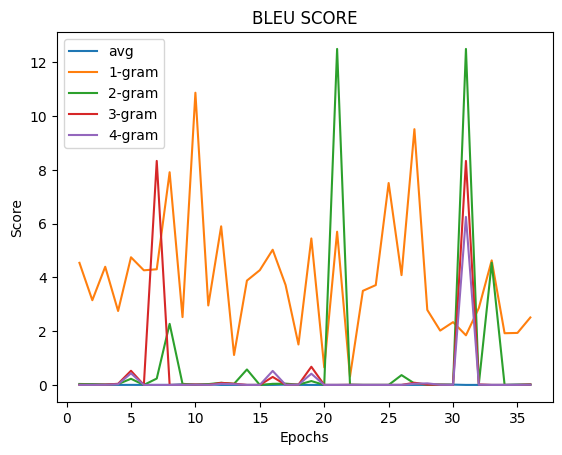

In [118]:
# 訓練模型
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    bleu_scores = []

    start_time = time.time()
    train_loss = train(path='{}/MODELS/translation_model({}).pth'.format(dir_path,model_name))
    #break
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Train Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    test_loss = evaluate()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Test Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()

    samples = get_samples(TEST_ZSENT,TEST_KSENT)
    test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
    #test_score = sacrebleu_score(model, source_sentences=TEST_ZSENT,target_sentences=TEST_KSENT,bpmf_sentences=TEST_ZYSENT,hanja_sentences=TEST_HSENT)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Eval Time: {epoch_mins}m {epoch_secs}s')

    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score:')
    for k in test_score.keys():
        print('\t\t{}: {:.3f}'.format(k,test_score[k]))
    #break
    #'''
    wandb.log({"Epoch_Train_loss": train_loss,
               "Epoch_Test_loss": test_loss,
               'BLEU_score(avg)':test_score['avg'],
               '1-gram':test_score['1-gram'],
               '2-gram':test_score['2-gram'],
               '3-gram':test_score['3-gram'],
               '4-gram':test_score['4-gram']})#'''

    # 儲存訓練好的模型
    if(test_score['avg'] > avg_best_score):
    #if(test_loss < best_loss):
      avg_best_score = avg_best_score['avg']
      best_loss = test_loss
      torch.save(model.state_dict(), '{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name))
      print('== save model ==')
        
    if(test_score['1-gram'] > best_score):
    #if(test_loss < best_loss):
      best_score = test_score['1-gram']
      best_loss = test_loss
      torch.save(model.state_dict(), '{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name))
      print('== save model ==')

    #break

    if(test_score['1-gram'] < 1):
      try:
        model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))
        print('='*5,'load best model','='*5)
      except:
        model = transformer.to(device)

        #'nothing'


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    bleu_scores.append(test_score)

    loss_history(train_losses, test_losses, path=model_name, to_show=False)
    sacrebleu_history(bleu_scores, path=model_name, to_show=False)
wandb.finish()

In [ ]:
bleu_score(test_source_sentences,model,tokenizer,max_length,device)

In [ ]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(source_sentences,target_sentences,lang='ko'):
  global zh_tokenizer, ko_tokenizer, model, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        source_tokens = zh_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = ko_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'] += bleu_score.score
        avg_score['1-gram'] += bleu_score.precisions[0]
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        pbar.update(1)
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)

  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [ ]:
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)